# Week 5 - Classifying Meanings & Documents

Recall that Week 1 of this course focused on how to find and extract text data, while weeks 2 through 4 each covered a different type of content representations:

2. computational linguistics (e.g., keyword count)
3. clustering and topic modeling (e.g., LDA)
4. embeddings (e.g., _word2vec_)

Now we show how classification, arguably the most common social science task, can be done with different representations. Note that the second representation, *clustering*, allows us to stably partition text data (e.g., documents, turns of conversation) according to all patterns of covariation among available text features. Classification, by contrast, partitions text data according to only those features and their variation that enable us to mimic and extrapolate human annotations.

We will show how to use a variety of classification methods, including Logistic regression, K-nearest neighbor, decision trees and random forests, support vector machines and even a simple neural network, the perceptron. We will also demonstrate ensemble techniques that can link several such methods into a single, more accurate, classification pipeline. We will finally learn to use conventions and metrics to evaluate classifier performance on out-of-sample data. 

In [1]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
#Make sure you update it before starting this notebook
import lucem_illud #pip install -U git+git://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git

#All these packages need to be installed from pip
#For ML
import sklearn
# import sklearn.naive_bayes
import sklearn.tree
import sklearn.ensemble
import sklearn.neural_network
import sklearn.decomposition
from sklearn.naive_bayes import GaussianNB

import numpy as np #arrays
import matplotlib.pyplot as plt #Plots
import scipy as sp #for interp

#These are from the standard library
import os.path
import pandas as pd

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning
%matplotlib inline

## Generating example data

We start by loading one of the "cartoon" or simplified data sets and then dividing it into training and testing sets. To maximize our ability to visualize, each dataset involves two classes, colored yellow and blue, arrayed along two dimensions (`x` and `y`). 

The four data patterns include: 
+ `random` in which the two classes are randomly distributed across both dimensions
+ `andSplit` in which the two classes are linearly split along one of two dimensions (e.g., men like Adidas)
+ `xorSplit` in which the two classes are split, oppositely, along each dimension (e.g., old ladies and young men like Nikes)
+ `targetSplit` in which one class is nested within the other in two dimensions (e.g., middle aged, middle income people like vintage Mustangs)
+ `multiBlobs` in which 5 classes are placed as bivariate Gaussians at random locations

`noise` is a variable [0-1] that ranges from no noise in the prescribed pattern [0] to complete noise/randomness [1].

Uncomment (remove the # in front of) each dataset, one at a time, and then run the cell and subsequent cells to examine how each machine learning approach captures each pattern.

We use the popular `train_test_split()` function from `sklearn`, and the data pattern function source code is copied below for your convenience from `lucem_illud`'s [cartoons.py](https://github.com/UChicago-Computational-Content-Analysis/lucem_illud/blob/main/lucem_illud/cartoons.py) file.

In [3]:
def random(numPerCategory = 500):
    datDict = {
        'vect' : [np.random.rand(2) * 2 - 1 for i in range(int(2 * numPerCategory))],
        'category' : [i % 2 for i in range(int(2 * numPerCategory))],
    }

    return pandas.DataFrame(datDict)

def andSplit(noise = 0, numPerCategory = 500):
    def genPoint(cat):
        y = np.random.random_sample() * 2 - 1
        if noise >= 0:
            x = np.random.random_sample() - cat - (np.random.random_sample() - cat) * noise
        else:
            x = (1 - noise * np.random.random_sample()) - cat
        return np.array([x, y])
    datDict = {
        'vect' : [genPoint(i % 2) for i in range(2 * numPerCategory)],
        'category' : [i % 2 for i in range(2 * numPerCategory)],
    }

    return pandas.DataFrame(datDict)

def xorSplit(noise = 0, numPerCategory = 500):
    def genPoint(cat):
        if cat == 1:
            if np.random.randint(0,2) < 1:
                y = np.random.random_sample() - np.random.random_sample() * noise * 2
                x = np.random.random_sample() - np.random.random_sample() * noise * 2
            else:
                y = np.random.random_sample() - 1 - np.random.random_sample() * noise * 2
                x = np.random.random_sample() - 1 - np.random.random_sample() * noise * 2
        else:
            if np.random.randint(0,2) < 1:
                y = np.random.random_sample() - 1 - np.random.random_sample() * noise * 2
                x = np.random.random_sample() - np.random.random_sample() * noise * 2
            else:
                y = np.random.random_sample() - np.random.random_sample() * noise * 2
                x = np.random.random_sample() - 1 - np.random.random_sample() * noise * 2
        return np.array([x, y])

    datDict = {
        'vect' : [genPoint(i % 2) for i in range(2 * numPerCategory)],
        'category' : [i % 2 for i in range(2 * numPerCategory)],
    }

    return pandas.DataFrame(datDict)

def targetSplit(noise = 0, numPerCategory = 500, innerRad = .3):
    def genPoint(cat):
        if cat == 0:
            r = np.random.random_sample() * innerRad + (1 - innerRad) * np.random.random_sample() * noise
        else:
            r = np.random.random_sample() * (1 - innerRad) + innerRad - innerRad * np.random.random_sample() * noise
        eta = 2 * np.pi * np.random.random_sample()
        return np.array([r * np.cos(eta), r * np.sin(eta)])

    datDict = {
        'vect' : [genPoint(i % 2) for i in range(2 * numPerCategory)],
        'category' : [i % 2 for i in range(2 * numPerCategory)],
    }

    return pandas.DataFrame(datDict)

def multiBlobs(noise = 0, numPerCategory = 500, centers = 5):
    if isinstance(centers, int):
        n_samples = numPerCategory * centers
    else:
        n_samples = numPerCategory * len(centers)
    X, y = sklearn.datasets.make_blobs(n_samples=n_samples, centers=centers, cluster_std = (.8 * (noise * 2 + 1)))
    datDict = {
        'vect' : list(X),
        'category' : y,
    }
    return pandas.DataFrame(datDict)

In [28]:
noise = .2

#bdfTrain, dfTest = sklearn.model_selection.train_test_split(lucem_illud.random(noise), test_size=.2)
#dfTrain, dfTest = sklearn.model_selection.train_test_split(lucem_illud.andSplit(noise), test_size=.2)
#dfTrain, dfTest = sklearn.model_selection.train_test_split(lucem_illud.xorSplit(noise), test_size=.2)
dfTrain, dfTest = sklearn.model_selection.train_test_split(lucem_illud.targetSplit(noise), test_size=.2)
#dfTrain, dfTest = sklearn.model_selection.train_test_split(lucem_illud.multiBlobs(noise), test_size=.2)

We can easily visualize the rendered datasets because they are generated in two dimensions.

Let's see what dfTrain, a simulated data that we just made, looks like

In [29]:
dfTrain

,vect,category
489,"[0.29475526484232845, -0.11665247431921451]",1
875,"[0.17908045051336774, 0.9126018343897012]",1
260,"[-0.26640425070192403, 0.13029775964646678]",0
90,"[-0.05315314133540713, 0.08894186450536103]",0
103,"[-0.07626815576363521, 0.32949811103067506]",1
...,...,...
129,"[0.6568493334821465, 0.22045543747309165]",1
212,"[-0.12376084731742457, -0.12305359151330938]",0
669,"[-0.011560356204416158, -0.48089866480731414]",1
279,"[-0.5956111482912482, 0.14109237394484753]",1


So, dfTrain has two columns, vect and category. We can plot this with `plotter()` from [lucem_illud/lucem_illud/cartoons.py](https://github.com/UChicago-Computational-Content-Analysis/lucem_illud/blob/main/lucem_illud/cartoons.py). Here's the source code:

In [3]:
def plotter(df):
    fig, ax = plt.subplots(figsize = (10,10))
    pallet = seaborn.color_palette(palette='rainbow', n_colors= len(set(df['category'])))
    for i, cat in enumerate(set(df['category'])):
        a = np.stack(df[df['category'] == cat]['vect'])
        ax.scatter(a[:,0], a[:, 1], c = pallet[i], label = cat)
    ax.legend(loc = 'center right', title = 'Categories')
    ax.axis('off')
    plt.show()
    plt.close()

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


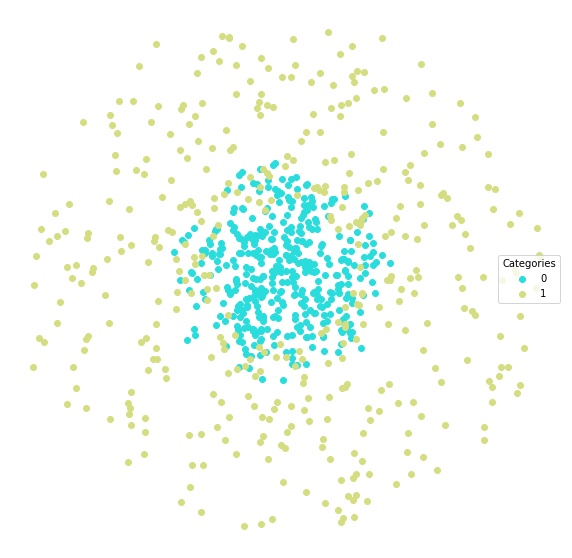

In [31]:
lucem_illud.plotter(dfTrain)

## Training a Machine Learning algorithm

We can now pick a model, there are many more options in `scikit-learn`. These are just a few examples, which array along the machine learning "tribes" described in Pedro Domingos _The Master Algorithm_.

Uncomment (remove the # in front of) each algorithm one at a time, then run the cell and subsequent cells to evaluate how it learns to understand the data.

In [32]:
#Bayes
#clf = sklearn.naive_bayes.GaussianNB()

#Analogizes
#clf = sklearn.svm.SVC(kernel = 'linear', probability = True) #slow, set probability = False to speed up
#clf = sklearn.svm.SVC(kernel = 'poly', degree = 3, probability = True) #slower
clf = sklearn.neighbors.KNeighborsClassifier(5, weights='distance')# k, 'distance' or 'uniform'

#Classical Regression
#clf = sklearn.linear_model.LogisticRegression()

#Symbolists
#clf = sklearn.tree.DecisionTreeClassifier()
#clf = sklearn.ensemble.RandomForestClassifier()

#Connectionists
#clf = sklearn.neural_network.MLPClassifier()

#Ensemble
#clf = sklearn.ensemble.GradientBoostingClassifier()

We're using sklearn here. What is sklearn? It's an open source machine learning library for Python. We use sklearn because it features various machine learning algorithms and it works well with NumPy library. You don't need to understand the sklearn package in detail for the moment, but let's see what methods and attributes sklearn has, because we're going to use some of them:

In [33]:
dir(sklearn)

['__SKLEARN_SETUP__',
 '__all__',
 '__builtins__',
 '__cached__',
 '__check_build',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '__version__',
 '_config',
 '_distributor_init',
 '_loss',
 'base',
 'clone',
 'config_context',
 'datasets',
 'decomposition',
 'dummy',
 'ensemble',
 'exceptions',
 'externals',
 'feature_extraction',
 'get_config',
 'linear_model',
 'logger',
 'logging',
 'metrics',
 'model_selection',
 'neighbors',
 'neural_network',
 'os',
 'preprocessing',
 'random',
 'set_config',
 'setup_module',
 'show_versions',
 'svm',
 'sys',
 'tree',
 'utils']

Now we fit the model by giving it our training data

In [34]:
clf.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])

KNeighborsClassifier(weights='distance')

Here, "stack" function is used. Why did we use stack function here? This is because dfTrain['vect'] is a sequence, while clf.fit() takes an array element. Let's see what dfTrain['vect'] looks like:

In [35]:
dfTrain['vect']

489      [0.29475526484232845, -0.11665247431921451]
875        [0.17908045051336774, 0.9126018343897012]
260      [-0.26640425070192403, 0.13029775964646678]
90       [-0.05315314133540713, 0.08894186450536103]
103      [-0.07626815576363521, 0.32949811103067506]
                           ...                      
129        [0.6568493334821465, 0.22045543747309165]
212     [-0.12376084731742457, -0.12305359151330938]
669    [-0.011560356204416158, -0.48089866480731414]
279       [-0.5956111482912482, 0.14109237394484753]
602    [0.20634655334492047, -0.0022404628678804367]
Name: vect, Length: 800, dtype: object

And let's see what np.stack(dfTrain['vect']) does:

In [36]:
np.stack(dfTrain['vect'])

array([[ 0.29475526, -0.11665247],
       [ 0.17908045,  0.91260183],
       [-0.26640425,  0.13029776],
       ...,
       [-0.01156036, -0.48089866],
       [-0.59561115,  0.14109237],
       [ 0.20634655, -0.00224046]])

As you can see, stack function takes a sequence of arrays (which have the same shape) and joins them along a new axis.

## Algorithm evaluation

We can look at few measurements of each classifier's performance by using the testing set. These `lucem_illud` functions are in [metrics.py](https://github.com/UChicago-Computational-Content-Analysis/lucem_illud/blob/main/lucem_illud/metrics.py), and we will skip copying source code this time due to length.

In [37]:
lucem_illud.evaluateClassifier(clf, dfTest)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.145,0.855036,0.85,0.799798,0.858586
1,0.145,0.855036,0.86,0.807277,0.851485


This lets us look at which classes do better:

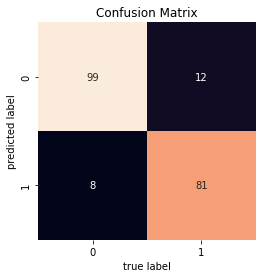

In [14]:
lucem_illud.plotConfusionMatrix(clf, dfTest)

The greater the area under the curve the better.

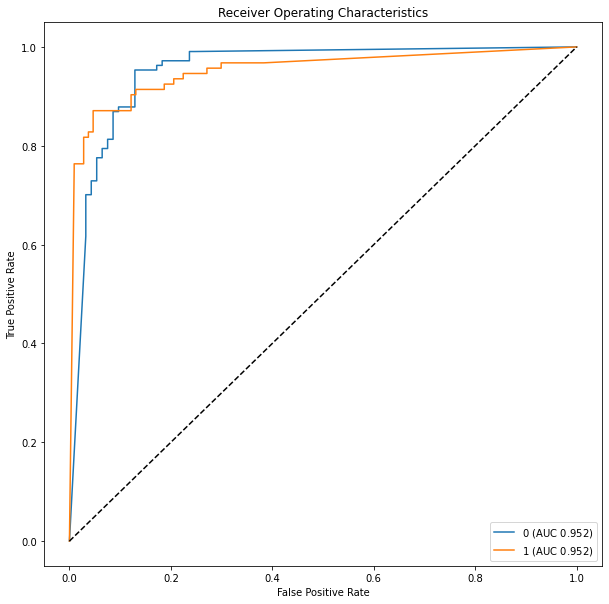

In [15]:
lucem_illud.plotMultiROC(clf, dfTest)

We can also look at the regions the classifer identifies as one class or the other:

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


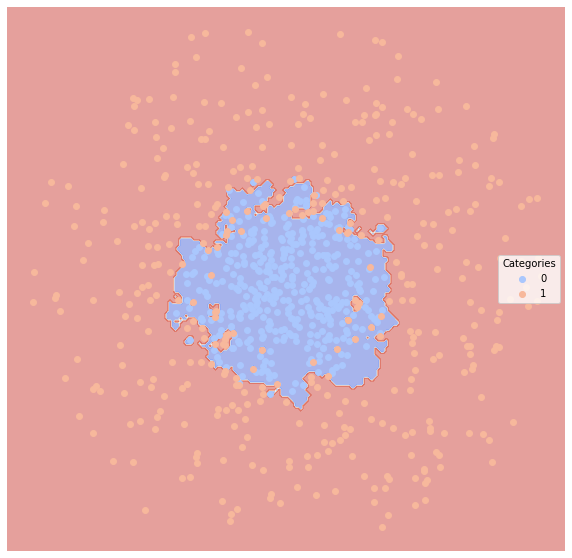

In [16]:
lucem_illud.plotregions(clf, dfTrain)

## Now we do the same for real data

Available data sets include:
+ Reddit threads "classified" by thread topic
+ 20 newsgroups "classified" by group topic
+ Senate press releases "classified" by Senator (2 senators)
+ Senate press releases "classified" by Senator (5 senators)
+ Emails classified as Spam or Ham

In [19]:
dfTrain, dfTest = sklearn.model_selection.train_test_split(lucem_illud.loadReddit(), test_size=.2)
#dfTrain, dfTest = sklearn.model_selection.train_test_split(lucem_illud.loadNewsGroups(), test_size=.2)
#dfTrain, dfTest = sklearn.model_selection.train_test_split(lucem_illud.loadSenateSmall(), test_size=.2)
#dfTrain, dfTest = sklearn.model_selection.train_test_split(lucem_illud.loadSenateLarge(), test_size=.2)
#dfTrain, dfTest = sklearn.model_selection.train_test_split(lucem_illud.loadSpam(), test_size=.2)

Loading Reddit data
Converting to vectors


D:\MySoftware\python310\lib\site-packages\spacy\pipeline\lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)
D:\MySoftware\python310\lib\site-packages\spacy\pipeline\lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


In [22]:
#Classical Regression
clf = sklearn.linear_model.LogisticRegression()

#Bayes
# clf = sklearn.naive_bayes.GaussianNB()

#Analogizes
#clf = sklearn.svm.SVC(kernel = 'linear', probability = True) #slow, set probability = False to speed up, but lose ROC
#clf = sklearn.svm.SVC(kernel = 'poly', degree = 3, probability = True) #slower
#clf = sklearn.neighbors.KNeighborsClassifier(5, weights='distance')# k, 'distance' or 'uniform'

#Symbolists
#clf = sklearn.tree.DecisionTreeClassifier()
#clf = sklearn.ensemble.RandomForestClassifier()

#Connectionists
#clf = sklearn.neural_network.MLPClassifier()

#Ensemble
#clf = sklearn.ensemble.GradientBoostingClassifier()

In [23]:
clf.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])

LogisticRegression()

In [24]:
lucem_illud.evaluateClassifier(clf, dfTest)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
Relationships,0.021875,0.966001,0.975309,0.932880,0.940476
Tales From Tech Support,0.009375,0.993450,0.968085,0.968085,1.000000
Bad Roommates,0.021875,0.968459,0.961538,0.925353,0.949367
Weeaboo Tales,0.009375,0.988487,0.970149,0.958575,0.984848


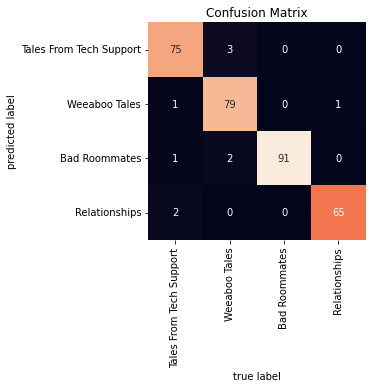

In [25]:
lucem_illud.plotConfusionMatrix(clf, dfTest)

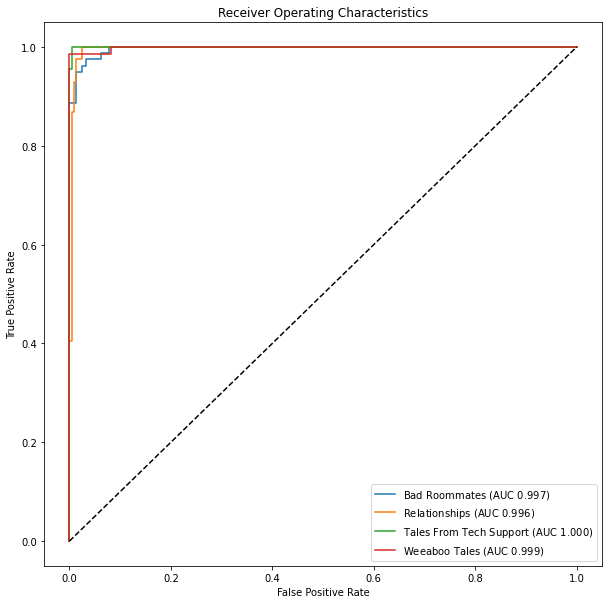

In [26]:
lucem_illud.plotMultiROC(clf, dfTest)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

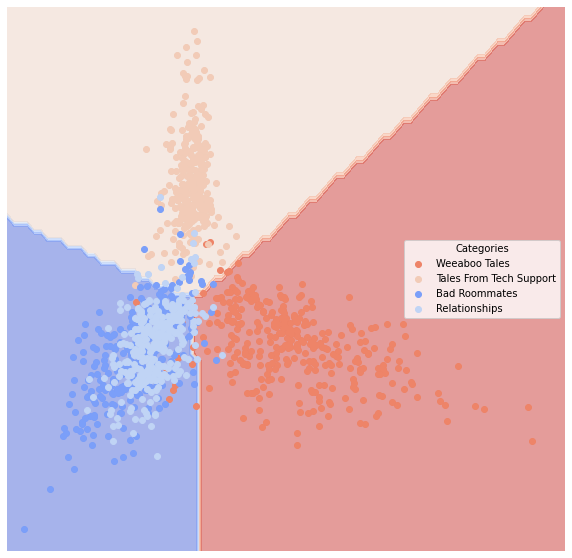

In [27]:
lucem_illud.plotregions(clf, dfTrain)

------

## <font color="red">*Exercise 1*</font>

<font color="red">Go back through all of the cells above and generate 10 distinct artificial datasets and classify them with all of the available methods. Add a cell immediately below and describe which classifier(s) worked best with which artificially constructed data source and why. Then go through all of the empirical datasets (i.e., Newsgroups, Senate Small, Senate Large, Email Spam) and classify them with all available methods. Add a second cell immediately below and describe which classifier(s) worked best with which data set and why.

<font color="red">***Stretch*** (but also required) Wander through the SKLearn documentation available [here](http://scikit-learn.org/stable/), particularly perusing the classifiers. In cells following, identify and implement a new classifier that we have not yet used (e.g., AdaBoost, CART) on one artificial dataset and one real dataset (used above). Then, in the next cell describe the classifier, detail how it compares with the approaches above, and why it performed better or worse than others.

### Task 1: Generate 10 distinct artificial datasets

In [4]:
import pandas
noise = .2

dfTrain1, dfTest1 = sklearn.model_selection.train_test_split(random(), test_size=.2)
dfTrain2, dfTest2 = sklearn.model_selection.train_test_split(random(), test_size=.2)
dfTrain3, dfTest3 = sklearn.model_selection.train_test_split(lucem_illud.andSplit(noise), test_size=.2)
dfTrain4, dfTest4 = sklearn.model_selection.train_test_split(lucem_illud.andSplit(noise), test_size=.2)
dfTrain5, dfTest5 = sklearn.model_selection.train_test_split(lucem_illud.xorSplit(noise), test_size=.2)
dfTrain6, dfTest6 = sklearn.model_selection.train_test_split(lucem_illud.xorSplit(noise), test_size=.2)
dfTrain7, dfTest7 = sklearn.model_selection.train_test_split(lucem_illud.targetSplit(noise), test_size=.2)
dfTrain8, dfTest8 = sklearn.model_selection.train_test_split(lucem_illud.targetSplit(noise), test_size=.2)
dfTrain9, dfTest9 = sklearn.model_selection.train_test_split(lucem_illud.multiBlobs(noise), test_size=.2)
dfTrain10, dfTest10 = sklearn.model_selection.train_test_split(lucem_illud.multiBlobs(noise), test_size=.2)

### Task 2: Classify artificial datasets

#### (1) random() datasets

In [6]:
clf1 = GaussianNB()
clf2 = sklearn.svm.SVC(kernel = 'linear', probability = True) 
clf3 = sklearn.neighbors.KNeighborsClassifier(5, weights='distance')# k, 'distance' or 'uniform'
clf4 = sklearn.linear_model.LogisticRegression()

#Symbolists
clf5 = sklearn.tree.DecisionTreeClassifier()
clf6 = sklearn.ensemble.RandomForestClassifier()

#Connectionists
clf7 = sklearn.neural_network.MLPClassifier()

#Ensemble
clf8 = sklearn.ensemble.GradientBoostingClassifier()

In [58]:
clf1.fit(np.stack(dfTrain1['vect'], axis=0), dfTrain1['category'])
clf2.fit(np.stack(dfTrain1['vect'], axis=0), dfTrain1['category'])
clf3.fit(np.stack(dfTrain1['vect'], axis=0), dfTrain1['category'])
clf4.fit(np.stack(dfTrain1['vect'], axis=0), dfTrain1['category'])
clf5.fit(np.stack(dfTrain1['vect'], axis=0), dfTrain1['category'])
clf6.fit(np.stack(dfTrain1['vect'], axis=0), dfTrain1['category'])
clf7.fit(np.stack(dfTrain1['vect'], axis=0), dfTrain1['category'])
clf8.fit(np.stack(dfTrain1['vect'], axis=0), dfTrain1['category'])

GradientBoostingClassifier()

In [60]:
lucem_illud.evaluateClassifier(clf1, dfTest1)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.525,0.480952,0.459677,0.465806,0.600000
1,0.525,0.480952,0.500000,0.515952,0.361905


In [61]:
lucem_illud.evaluateClassifier(clf2, dfTest1)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.505,0.496176,0.456311,0.458115,0.510870
1,0.505,0.496176,0.536082,0.538114,0.481481


In [62]:
lucem_illud.evaluateClassifier(clf3, dfTest1)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.555,0.449074,0.414414,0.437207,0.500000
1,0.555,0.449074,0.483146,0.517364,0.398148


In [63]:
lucem_illud.evaluateClassifier(clf4, dfTest1)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.5,0.508857,0.467213,0.464469,0.619565
1,0.5,0.508857,0.551282,0.544492,0.398148


In [64]:
lucem_illud.evaluateClassifier(clf5, dfTest1)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.505,0.490539,0.449438,0.455408,0.434783
1,0.505,0.490539,0.531532,0.535374,0.546296


In [65]:
lucem_illud.evaluateClassifier(clf6, dfTest1)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.5,0.503221,0.462963,0.46161,0.543478
1,0.5,0.503221,0.543478,0.54161,0.462963


In [66]:
lucem_illud.evaluateClassifier(clf7, dfTest1)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.545,0.464775,0.432000,0.443565,0.586957
1,0.545,0.464775,0.493333,0.524012,0.342593


In [67]:
lucem_illud.evaluateClassifier(clf8, dfTest1)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.455,0.549718,0.504505,0.487090,0.608696
1,0.455,0.549718,0.595506,0.567239,0.490741


Since this generator just gives random numbers, it's within expectation that no classifiers can possibly distinguish it. The error rates from all of the classifiers are around 0.5.

In [7]:
clf1.fit(np.stack(dfTrain2['vect'], axis=0), dfTrain2['category'])
clf2.fit(np.stack(dfTrain2['vect'], axis=0), dfTrain2['category'])
clf3.fit(np.stack(dfTrain2['vect'], axis=0), dfTrain2['category'])
clf4.fit(np.stack(dfTrain2['vect'], axis=0), dfTrain2['category'])
clf5.fit(np.stack(dfTrain2['vect'], axis=0), dfTrain2['category'])
clf6.fit(np.stack(dfTrain2['vect'], axis=0), dfTrain2['category'])
clf7.fit(np.stack(dfTrain2['vect'], axis=0), dfTrain2['category'])
clf8.fit(np.stack(dfTrain2['vect'], axis=0), dfTrain2['category'])

NameError: name 'clf1' is not defined

In [70]:
lucem_illud.evaluateClassifier(clf1, dfTest2)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.5,0.506266,0.480000,0.478158,0.631579
1,0.5,0.506266,0.533333,0.528175,0.380952


In [71]:
lucem_illud.evaluateClassifier(clf2, dfTest2)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.495,0.506516,0.481132,0.478292,0.536842
1,0.495,0.506516,0.531915,0.528293,0.476190


In [72]:
lucem_illud.evaluateClassifier(clf3, dfTest2)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.52,0.481704,0.457944,0.466203,0.515789
1,0.52,0.481704,0.505376,0.516216,0.447619


In [73]:
lucem_illud.evaluateClassifier(clf4, dfTest2)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.465,0.538095,0.508929,0.495357,0.60000
1,0.465,0.538095,0.568182,0.545563,0.47619


In [74]:
lucem_illud.evaluateClassifier(clf5, dfTest2)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.495,0.503509,0.478723,0.476764,0.473684
1,0.495,0.503509,0.528302,0.526761,0.533333


In [75]:
lucem_illud.evaluateClassifier(clf6, dfTest2)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.435,0.565664,0.539216,0.512178,0.578947
1,0.435,0.565664,0.591837,0.561919,0.552381


In [76]:
lucem_illud.evaluateClassifier(clf7, dfTest2)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.49,0.516792,0.488189,0.483608,0.652632
1,0.49,0.516792,0.547945,0.533741,0.380952


In [77]:
lucem_illud.evaluateClassifier(clf8, dfTest2)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.555,0.445363,0.421569,0.450815,0.452632
1,0.555,0.445363,0.469388,0.500637,0.438095


Not surprisingly, same as before. I feel that the quality of the classifiers is actually measuring the quality of the random number generator.

From here on I decided to define a function to automaify the process.

In [7]:
import pandas as pd
import numpy as np

clfs = [clf1,clf2,clf3,clf4,clf5,clf6,clf7,clf8]
clf_names = ['naive bayes','SVC','KNN','logistic','decision tree','random forest','MLP','gradient boosting']

def get_results(train,test):
    tables = []
    group_n = len(set(train['category']))
    for clf in clfs:
        clf.fit(np.stack(train['vect'], axis=0), train['category'])
        tables.append(lucem_illud.evaluateClassifier(clf, test))
    tables = pd.concat(tables)
    tables['clf_names'] = np.repeat(clf_names,group_n)
    return tables

In [46]:
get_results(dfTrain1,dfTest1)

,Error_Rate,AUC,Precision,Average_Precision,Recall,clf_names
Category,,,,,,
0,0.460,0.547890,0.482143,0.465860,0.613636,naive bayes
1,0.460,0.547890,0.613636,0.585860,0.482143,naive bayes
0,0.460,0.546672,0.481818,0.465186,0.602273,SVC
1,0.460,0.546672,0.611111,0.585099,0.491071,SVC
0,0.445,0.552760,0.494737,0.469234,0.534091,KNN
1,0.445,0.552760,0.609524,0.588299,0.571429,KNN
0,0.460,0.547890,0.482143,0.465860,0.613636,logistic
1,0.460,0.547890,0.613636,0.585860,0.482143,logistic
0,0.460,0.543019,0.480769,0.463164,0.568182,decision tree


In [ ]:
get_results(dfTrain3,dfTest3)

In [100]:
get_results(dfTrain4,dfTest4)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.105,0.891420,0.905983,0.877881,0.913793
1,0.105,0.891420,0.879518,0.819343,0.869048
0,0.105,0.891420,0.905983,0.877881,0.913793
1,0.105,0.891420,0.879518,0.819343,0.869048
0,0.120,0.875205,0.889831,0.860450,0.905172
1,0.120,0.875205,0.865854,0.796852,0.845238
0,0.105,0.891420,0.905983,0.877881,0.913793
1,0.105,0.891420,0.879518,0.819343,0.869048
0,0.100,0.900657,0.928571,0.892512,0.896552


In [101]:
get_results(dfTrain5,dfTest5)

D:\MySoftware\python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.640,0.369565,0.357143,0.409689,0.489130
1,0.640,0.369565,0.364865,0.496216,0.250000
0,0.625,0.407609,0.409836,0.419105,0.815217
1,0.625,0.407609,0.000000,0.540000,0.000000
0,0.110,0.890097,0.872340,0.827521,0.891304
1,0.110,0.890097,0.905660,0.865031,0.888889
0,0.640,0.368760,0.354839,0.409705,0.478261
1,0.640,0.368760,0.368421,0.495517,0.259259
0,0.115,0.886272,0.855670,0.816963,0.902174


In [55]:
get_results(dfTrain6,dfTest6)

D:\MySoftware\python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


,Error_Rate,AUC,Precision,Average_Precision,Recall,clf_names
Category,,,,,,
0,0.480,0.525573,0.555556,0.528781,0.339806,naive bayes
1,0.480,0.525573,0.503650,0.498266,0.711340,naive bayes
0,0.360,0.647483,0.803922,0.630008,0.398058,SVC
1,0.360,0.647483,0.583893,0.573698,0.896907,SVC
0,0.155,0.845311,0.860000,0.803058,0.834951,KNN
1,0.155,0.845311,0.830000,0.780206,0.855670,KNN
0,0.415,0.590181,0.651515,0.571992,0.417476,logistic
1,0.415,0.590181,0.552239,0.536296,0.762887,logistic
0,0.120,0.879592,0.876190,0.837617,0.893204,decision tree


In [54]:
get_results(dfTrain7,dfTest7)

D:\MySoftware\python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\MySoftware\python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


,Error_Rate,AUC,Precision,Average_Precision,Recall,clf_names
Category,,,,,,
0,0.055,0.944614,0.955752,0.935449,0.947368,naive bayes
1,0.055,0.944614,0.931034,0.901905,0.941860,naive bayes
0,0.570,0.500000,0.000000,0.570000,0.000000,SVC
1,0.570,0.500000,0.430000,0.430000,1.000000,SVC
0,0.060,0.937373,0.939655,0.923442,0.956140,KNN
1,0.060,0.937373,0.940476,0.898926,0.918605,KNN
0,0.640,0.392901,0.360000,0.536842,0.157895,logistic
1,0.640,0.392901,0.360000,0.386047,0.627907,logistic
0,0.080,0.922685,0.953704,0.916680,0.903509,decision tree


In [104]:
get_results(dfTrain8,dfTest8)

D:\MySoftware\python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.085,0.914841,0.903846,0.876203,0.930693
1,0.085,0.914841,0.927083,0.883439,0.898990
0,0.330,0.667467,0.615894,0.607110,0.920792
1,0.330,0.667467,0.836735,0.636526,0.414141
0,0.130,0.869987,0.871287,0.824141,0.871287
1,0.130,0.869987,0.868687,0.819617,0.868687
0,0.485,0.515602,0.522727,0.513074,0.455446
1,0.485,0.515602,0.508929,0.503019,0.575758
0,0.145,0.855236,0.875000,0.812723,0.831683


In [52]:
get_results(dfTrain9,dfTest9,5)

D:\MySoftware\python310\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\MySoftware\python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


,Error_Rate,AUC,Precision,Average_Precision,Recall,clf_names
Category,,,,,,
0,0.120,0.797707,0.681319,0.516212,0.666667,naive bayes
1,0.000,1.000000,1.000000,1.000000,1.000000,naive bayes
2,0.010,0.986427,0.970874,0.955837,0.980392,naive bayes
3,0.152,0.763954,0.643564,0.478397,0.619048,naive bayes
4,0.026,0.968028,0.910891,0.880937,0.958333,naive bayes
0,0.124,0.811841,0.653465,0.517750,0.709677,SVC
1,0.000,1.000000,1.000000,1.000000,1.000000,SVC
2,0.010,0.986427,0.970874,0.955837,0.980392,SVC
3,0.158,0.735684,0.644444,0.449979,0.552381,SVC


In [108]:
get_results(dfTrain10,dfTest10)

D:\MySoftware\python310\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.002,0.998753,0.990000,0.990000,1.000000
1,0.002,0.994565,1.000000,0.991130,0.989130
2,0.004,0.993105,0.988636,0.979402,0.988636
3,0.000,1.000000,1.000000,1.000000,1.000000
4,0.004,0.994353,0.991304,0.984684,0.991304
0,0.002,0.998753,0.990000,0.990000,1.000000
1,0.002,0.994565,1.000000,0.991130,0.989130
2,0.006,0.987423,0.988506,0.970040,0.977273
3,0.000,1.000000,1.000000,1.000000,1.000000


### Task 3: Interogation

**Q1: which classifier(s) worked best with which artificially constructed data?**

A1: The two datasets generated from the `multiBlobs` function seems to be the "easiest" task. For all the other data, the classifers can reach an error rate of at best 0.1, while for the two datasets (#9 and #10), the error rate for some categories can be as low as zero.

Let's visualize #1 and #10 dataset.

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


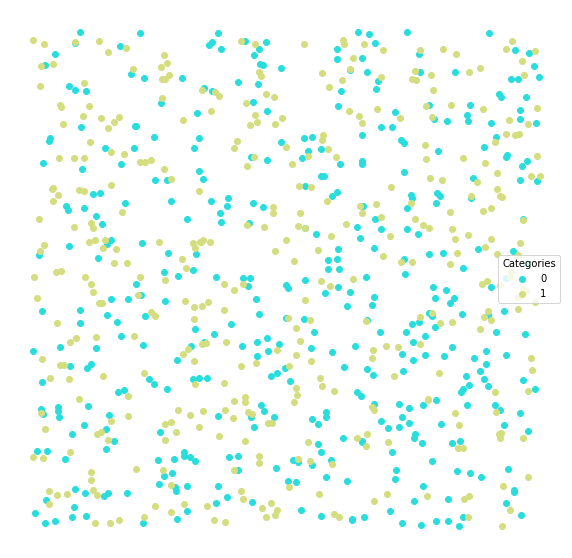

In [44]:
lucem_illud.plotter(dfTrain1)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


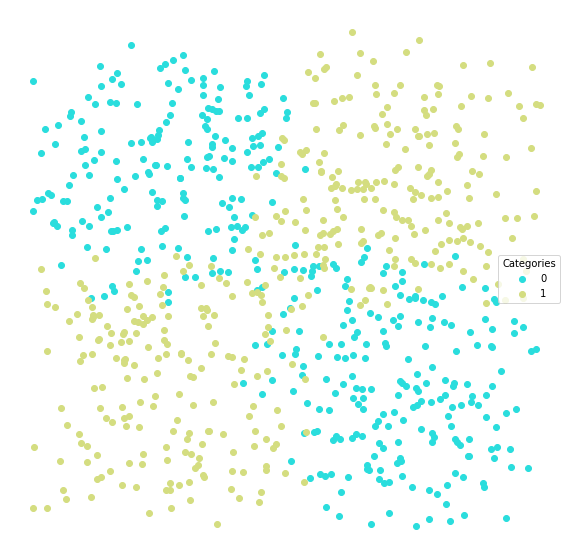

In [56]:
lucem_illud.plotter(dfTrain6)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

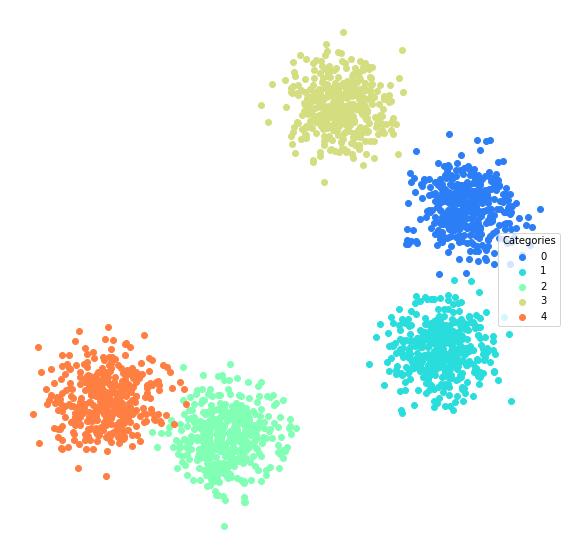

In [109]:
lucem_illud.plotter(dfTrain10)

We can see that they are basically seperate and have very clear boundries. No wonder the classifiers make such success.

I also found that the classifers seem to be performing better and better (I reruned the `get_results` function for a few times), and in the end, the error rate can be extremely low. All the classfiers seem to be learning from the whole process.

Since all the classifiers reach a pretty excellent results for dataset #9 and #10, let's compare previous results to compare the classifiers. Specifically, let's look at dataset #8.

The naive Bayes algorithm gave us the lowest error rates, followed by the multi-layer neural network. The possible reason is that we have a relatively small dataset (only 500), and naive bayes is very suitable for working around with small sample. 

### Task 4: Go through the empirical datasets

In [5]:
dfTrain_n, dfTest_n = sklearn.model_selection.train_test_split(lucem_illud.loadNewsGroups(), test_size=.2)
dfTrain_ss, dfTest_ss = sklearn.model_selection.train_test_split(lucem_illud.loadSenateSmall(), test_size=.2)
dfTrain_sl, dfTest_sl = sklearn.model_selection.train_test_split(lucem_illud.loadSenateLarge(), test_size=.2)
dfTrain_sp, dfTest_sp = sklearn.model_selection.train_test_split(lucem_illud.loadSpam(), test_size=.2)

Loading data for: comp.sys.mac.hardware
Loading data for: comp.windows.x
Loading data for: misc.forsale
Loading data for: rec.autos
Converting to vectors


D:\MySoftware\python310\lib\site-packages\spacy\pipeline\lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)
D:\MySoftware\python310\lib\site-packages\spacy\pipeline\lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


Loading senate data
Converting to vectors


D:\MySoftware\python310\lib\site-packages\spacy\pipeline\lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)
D:\MySoftware\python310\lib\site-packages\spacy\pipeline\lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


Loading senator: Kennedy
Loading senator: Kerry
Loading senator: Klobuchar
Loading senator: Kohl
Loading senator: Kyl
Converting to vectors


D:\MySoftware\python310\lib\site-packages\spacy\pipeline\lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)
D:\MySoftware\python310\lib\site-packages\spacy\pipeline\lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


Loading Spam
Loading Ham
Converting to vectors


D:\MySoftware\python310\lib\site-packages\spacy\pipeline\lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)
D:\MySoftware\python310\lib\site-packages\spacy\pipeline\lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


In [ ]:
get_results(dfTrain_n,dfTest_n)

,Error_Rate,AUC,Precision,Average_Precision,Recall,clf_names
Category,,,,,,
comp.windows.x,0.068085,0.922244,0.811966,0.755912,0.904762,naive bayes
comp.sys.mac.hardware,0.155319,0.812798,0.629921,0.530731,0.754717,naive bayes
rec.autos,0.110638,0.858319,0.792000,0.682583,0.792000,naive bayes
misc.forsale,0.138298,0.793355,0.841584,0.638096,0.634328,naive bayes
comp.windows.x,0.021277,0.969341,0.952381,0.917668,0.952381,SVC
comp.sys.mac.hardware,0.072340,0.896460,0.839623,0.741136,0.839623,SVC
rec.autos,0.059574,0.944116,0.843972,0.816227,0.952000,SVC
misc.forsale,0.080851,0.882885,0.906780,0.781517,0.798507,SVC
comp.windows.x,0.193617,0.576843,0.850000,0.324853,0.161905,KNN


In [ ]:
get_results(dfTrain_ss,dfTest_ss)

,Error_Rate,AUC,Precision,Average_Precision,Recall,clf_names
Category,,,,,,
Obama,0.140351,0.850468,0.871212,0.776872,0.787671,naive bayes
Clinton,0.140351,0.850468,0.852381,0.828158,0.913265,naive bayes
Obama,0.005848,0.993151,1.000000,0.992149,0.986301,SVC
Clinton,0.005848,0.993151,0.989899,0.989899,1.000000,SVC
Obama,0.125731,0.871960,0.850340,0.789434,0.856164,KNN
Clinton,0.125731,0.871960,0.892308,0.856478,0.887755,KNN
Obama,0.011696,0.986301,1.000000,0.984299,0.972603,logistic
Clinton,0.011696,0.986301,0.980000,0.980000,1.000000,logistic
Obama,0.008772,0.991473,0.986395,0.982562,0.993151,decision tree


In [ ]:
get_results(dfTrain_sl,dfTest_sl)

,Error_Rate,AUC,Precision,Average_Precision,Recall,clf_names
Category,,,,,,
Kennedy,0.248399,0.767904,0.658052,0.645209,0.937677,naive bayes
Kyl,0.080666,0.697376,0.886364,0.430637,0.402062,naive bayes
Kohl,0.051216,0.755537,0.976190,0.550234,0.512500,naive bayes
Kerry,0.133163,0.781154,0.722973,0.535714,0.629412,naive bayes
Klobuchar,0.057618,0.744056,0.909091,0.501431,0.493827,naive bayes
Kennedy,0.020487,0.980067,0.969359,0.962031,0.985836,SVC
Kyl,0.007682,0.977919,0.978947,0.943700,0.958763,SVC
Kohl,0.002561,0.987500,1.000000,0.977561,0.975000,SVC
Kerry,0.011524,0.982021,0.976331,0.954018,0.970588,SVC


In [ ]:
get_results(dfTrain_sp,dfTest_sp)

,Error_Rate,AUC,Precision,Average_Precision,Recall,clf_names
Category,,,,,,
spam,0.169343,0.799406,0.458333,0.382493,0.754902,naive bayes
not spam,0.169343,0.799406,0.951644,0.935949,0.843911,naive bayes
spam,0.102190,0.705395,0.785714,0.423607,0.431373,SVC
not spam,0.102190,0.705395,0.907790,0.906623,0.979417,SVC
spam,0.116788,0.672552,0.703704,0.355595,0.372549,KNN
not spam,0.116788,0.672552,0.898574,0.897271,0.972556,KNN
spam,0.122628,0.596324,0.909091,0.297961,0.196078,logistic
not spam,0.122628,0.596324,0.876320,0.876233,0.996569,logistic
spam,0.109489,0.737505,0.670886,0.420131,0.519608,decision tree


**Comments**:
1. The Support Vector Machine and the Neural Network did the best job in distinguishing between different news groups. They are also the best ones in classifying spam emails versus non-spam emails. 
    * The potential reason: I googled about the pros of Support Vector Machine and I found that it perfroms well for classification tasks with a clear margin of seperation. So may be the classification task with news groups and spam emails have a clear margin in a high dimensional space.
2. The Support Vector Machine, Decision Tree, Random Forest, Neural Network and Gradient boosting all did impressive job in the small and large senate press release task. Maybe it is because and there are clear differences between each person's releases.

### Task 5: Implement a new identifier with one artificial dataset and one real dataset

For this task, I will use the artificial dataset #6 and the news group dataset.

In [8]:
dfTrain_n, dfTest_n = sklearn.model_selection.train_test_split(lucem_illud.loadNewsGroups(), test_size=.2)

Loading data for: comp.sys.mac.hardware
Loading data for: comp.windows.x
Loading data for: misc.forsale
Loading data for: rec.autos
Converting to vectors


D:\MySoftware\python310\lib\site-packages\spacy\pipeline\lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)
D:\MySoftware\python310\lib\site-packages\spacy\pipeline\lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


In [9]:
from sklearn.ensemble import AdaBoostClassifier
clf_ada = AdaBoostClassifier(n_estimators=100)
clf_ada.fit(np.stack(dfTrain6['vect'], axis=0), dfTrain6['category'])
lucem_illud.evaluateClassifier(clf_ada, dfTest6)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.5,0.49697,0.446809,0.448511,0.466667
1,0.5,0.49697,0.547170,0.548508,0.527273


The result shows that the AdaBoost is just like Naive Bayes and Support Vector Machine, that it cannot draw a flexible boundary.

In [10]:
clf_ada.fit(np.stack(dfTrain_n['vect'], axis=0), dfTrain_n['category'])
lucem_illud.evaluateClassifier(clf_ada, dfTest_n)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
misc.forsale,0.129787,0.782475,0.758621,0.557455,0.622642
comp.sys.mac.hardware,0.142553,0.775992,0.734043,0.545658,0.621622
comp.windows.x,0.097872,0.863462,0.855932,0.726696,0.776923
rec.autos,0.208511,0.793187,0.573099,0.509807,0.796748


Its performance is...not very impressive. Perhaps it needs more tuning.

-----

# Clinton / Obama Press Releases

We often will not have nicely prepared data, so we will work though the proccess of cleaning and structuring in more detail here:

While the Clinton and Obama Senatorial Press Releases are not hand-coded, we can imagine that we have been given a stack of such press releases, but lost the metadata associated with which senatorial office issued which. If we label a few of them, how well can our classifier do at recovering the rest? 

In [12]:
ObamaClintonReleases = pd.read_csv('../data/ObamaClintonReleases.csv', index_col=0)

I'm pretty sure that you're all familiar with pandas, but, just to clarify: why do we use pandas here? pandas is a Python library which is widely used for analyzing and wrangling data. In particular, pandas loads data and creates data frame, a Python object that looks familiar to us (since it looks like a excel table) and easy to work with. So, using pandas.read_csv function, we take in the csv file and convert it into a data frame. 

In [4]:
type(ObamaClintonReleases)

pandas.core.frame.DataFrame

It's a DataFrame! and it looks like this:

In [5]:
ObamaClintonReleases

,download_url,html_url,name,path,text,targetSenator
0,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Apr2007Obama430.txt,raw/Obama/10Apr2007Obama430.txt,Obama Calls on IRS to Protect Taxpayers ...,Obama
1,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Apr2008Obama108.txt,raw/Obama/10Apr2008Obama108.txt,Statement from Senator Barack Obama on the ...,Obama
2,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Aug2005Obama674.txt,raw/Obama/10Aug2005Obama674.txt,Obama Says Bill Will Help Cut Off Supply of...,Obama
3,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Aug2005Obama675.txt,raw/Obama/10Aug2005Obama675.txt,Obama Durbin Say Illinois Will Receive 33 ...,Obama
4,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Aug2006Obama508.txt,raw/Obama/10Aug2006Obama508.txt,Obama Introduces Bill to Help Tap Power of ...,Obama
...,...,...,...,...,...,...
1704,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,1Sep2005Clinton285.txt,raw/Clinton/1Sep2005Clinton285.txt,September 1 2005 Senator Clinton Visit Infoto...,Clinton
1705,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,1Sep2005Clinton286.txt,raw/Clinton/1Sep2005Clinton286.txt,September 1 2005 Senator Clinton Announces Ex...,Clinton
1706,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,1Sep2005Clinton287.txt,raw/Clinton/1Sep2005Clinton287.txt,September 1 2005 Senator Clinton Joins Local ...,Clinton
1707,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,1Sep2006Clinton207.txt,raw/Clinton/1Sep2006Clinton207.txt,September 1 2006 Clintons Meet with Cazenovia...,Clinton


Neat! Let's turn the 'targetSenator' column into a binary category variable.

In [13]:
ObamaClintonReleases['category'] = [s == 'Obama' for s in ObamaClintonReleases['targetSenator']]

Tokenize and normalize

In [14]:
ObamaClintonReleases['tokenized_text'] = ObamaClintonReleases['text'].apply(lambda x: lucem_illud.word_tokenize(x))
ObamaClintonReleases['normalized_text'] = ObamaClintonReleases['tokenized_text'].apply(lambda x: lucem_illud.normalizeTokens(x))

D:\MySoftware\python310\lib\site-packages\spacy\pipeline\lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)
D:\MySoftware\python310\lib\site-packages\spacy\pipeline\lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


Let's split the data into training data and testing data.

In [15]:
holdBackFraction = .2
train_data_df, test_data_df = sklearn.model_selection.train_test_split(ObamaClintonReleases, test_size=holdBackFraction)

In [16]:
print(len(train_data_df))
print(len(test_data_df))

1367
342


## Logistic Regression

First, let's try with a logistic regression, which may be familiar to you from statistical methods classes. First, we must turn the training dataset into a tf-idf matrix (`lucem_illud.generateVecs()` will help with this but for now we are doing it the long way):

In [17]:
TFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=2, stop_words='english', norm='l2')
TFVects = TFVectorizer.fit_transform(train_data_df['text'])

The core function here is TfidfVectorizer, which takes a collection of raw documents and turn them to a tf-idf matrix. Just to recap: tf-idf means term frequency-inverse document frequency, a statistic (or, more precisely, a product of two statistics, term frequency and inverse document frequency) that shows the importance of a term vis-a-vis documents. TF, or, term frequency, counts how many times a term is used in a document; IDF, or, inverse-document-frequency, measures common or rare a term appears across documents. 

Let's look at three parameters of TfidfVectorizer: max_df = 100, min_df = 2, and norm='l2'. What do those parameters mean? 

(1) max_df = 100

Here, we specified a thredhold of 100, and the terms that have a document frequency higher than 100 would be ignored.

(2) min_df = 2

We specified a lower bound, 2, and the terms that have a document frequency lower than 2 will be ignored.

(3) norm = 'l2'

This parameter is about vector normalization. In machine learning, we commonly normalize vectors, i.e., change the length of vectors and turn them into a unit vector, before passing them into algorithms. There are various ways of normalizations, and this parameter specifies how we normalize vectors. Here, we set the norm to l2, in which case, we normalize the vectors such that squares of vector elements sums to 1. Alternatively, we can set it to l1, in which case the sum of absolute values of vector elements, not the square of vector elements, is 1. 

fit_transform() literally fits to data and then transform it. So, fit_transform() is just a combination of two steps--(1) fitting parameters to data; (2) then, using the vocabulary and document frequencies learned by fit(), transforming documents into document-term matrix. So, it's the same as fit followed by transform. 

Note that we can use the CountVectorizer instead, which simply produces a matrix of word counts.

In [18]:
TFVects.shape

(1367, 11410)

We can save this in the dataframe to make things easier

In [19]:
train_data_df['vect'] = [np.array(v).flatten() for v in TFVects.todense()]

Looks simple, but we need to know what todense() does here. todense() returns a dense matrix representation of the matrix. Why do we need this? As you can see above, the TFVects, a document-term matrix, has 11349 columns, and this matrix is sparse, in the sense that it is comprised mostly of zeros. Dense matrices, in contrast, are the matrices that are comprised of mostly non-zeros. Then why do we make sparse matrices into dense ones? Because zero values don't contain important information but take up so much memory.

In a regression, we cannot have more variables than cases. So, we need to first do a dimension reduction. First, we will approah this with PCA. You have previously seen this in week 3. Here we are not concerned about visualization, but rather classification and so all principal components are calculated. Watch out: we have to use `stack` not `sum` for combining the vectors. We note that you could also use topic loading and embedding dimensions as featured variables.

In [20]:
pca = sklearn.decomposition.PCA()
reduced_data = pca.fit_transform(np.stack(train_data_df['vect'], axis=0))

We can store the PCA space vectors in the dataframe too:

In [21]:
train_data_df['pca'] = [r for r in reduced_data]

Visualization in 2D:

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


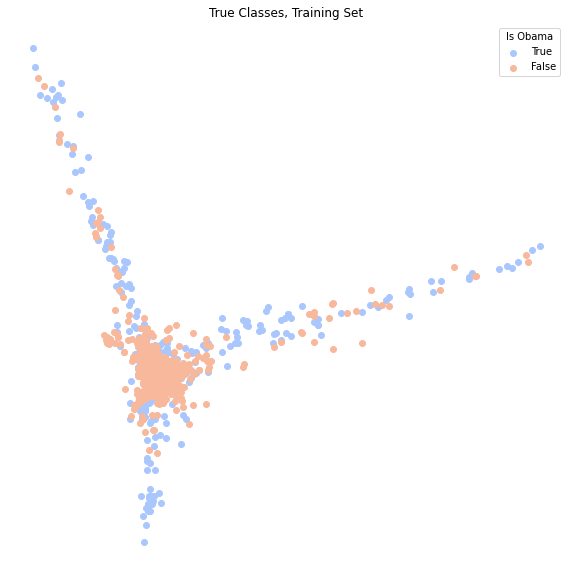

In [22]:
fig, ax = plt.subplots(figsize = (10,10))
ax.axis('off')
pallet = seaborn.color_palette(palette='coolwarm', n_colors = 2)

#Plot Obama
a = np.stack(train_data_df[train_data_df['category']]['pca'])
ax.scatter(a[:,0], a[:, 1], c = pallet[0], label = "True")

#Plot not Obama
a = np.stack(train_data_df[train_data_df['category'].eq(False)]['pca'])
ax.scatter(a[:,0], a[:, 1], c = pallet[1], label = "False")
    
ax.legend(loc = 'upper right', title = 'Is Obama')
plt.title('True Classes, Training Set')
plt.show()

PCA cannot distinguish Obama very well. Let's perform a screeplot to see how many Principal Components we need.

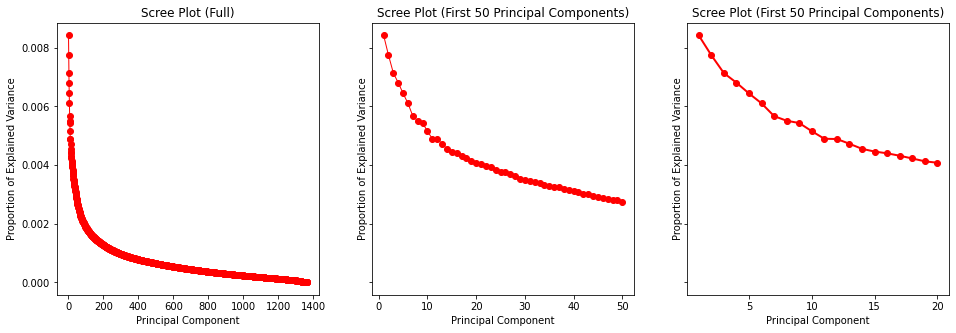

In [23]:
n = len(train_data_df)

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize = (16, 5), sharey=True)

eigen_vals = np.arange(n) + 1
ax1.plot(eigen_vals, pca.explained_variance_ratio_, 'ro-', linewidth=1)
ax1.set_title('Scree Plot (Full)')
ax1.set_xlabel('Principal Component')
ax1.set_ylabel('Proportion of Explained Variance')

eigen_vals = np.arange(50) + 1
ax2.plot(eigen_vals, pca.explained_variance_ratio_[:50], 'ro-', linewidth=1)
ax2.set_title('Scree Plot (First 50 Principal Components)')
ax2.set_xlabel('Principal Component')
ax2.set_ylabel('Proportion of Explained Variance')


eigen_vals = np.arange(20) + 1
ax3.plot(eigen_vals, pca.explained_variance_ratio_[:20], 'ro-', linewidth=2)
ax3.set_title('Scree Plot (First 50 Principal Components)')
ax3.set_xlabel('Principal Component')
ax3.set_ylabel('Proportion of Explained Variance')

plt.show()

Let's choose the first 10 pricipal components as our covariates.

In [24]:
train_data_df['pca_reduced_10'] = train_data_df['pca'].apply(lambda x: x[:10])

Now we fit a logistic regression to our data.

In [25]:
logistic = sklearn.linear_model.LogisticRegression()
logistic.fit(np.stack(train_data_df['pca_reduced_10'], axis=0), train_data_df['category'])

LogisticRegression()

Let's see how the logistic regression performs on the training dataset from which we develop the model. Unfortunately, the mean accuracy is only about 64%.

In [26]:
logistic.score(np.stack(train_data_df['pca_reduced_10'], axis=0), train_data_df['category'])

0.6854425749817118

How does it perform on the testing dataset, which we "held out" and did not use for model training? We need to repeat all the steps on the testing data, but without retraining:

In [27]:
#Create vectors
TFVects_test = TFVectorizer.transform(test_data_df['text'])
test_data_df['vect'] = [np.array(v).flatten() for v in TFVects_test.todense()]

#PCA
reduced_data_test = pca.transform(np.stack(test_data_df['vect'], axis=0))
test_data_df['pca'] = [r for r in reduced_data_test]
test_data_df['pca_reduced_10'] = test_data_df['pca'].apply(lambda x: x[:10])

#Test
logistic.score(np.stack(test_data_df['pca_reduced_10'], axis=0), test_data_df['category'])

0.7046783625730995

Slightly poorer. How about using more dimensions (40)?

In [28]:
train_data_df['pca_reduced_40'] = train_data_df['pca'].apply(lambda x: x[:40])
test_data_df['pca_reduced_40'] = test_data_df['pca'].apply(lambda x: x[:40])

logistic.fit(np.stack(train_data_df['pca_reduced_40'], axis=0), train_data_df['category'])

print("Training:")
print(logistic.score(np.stack(train_data_df['pca_reduced_40'], axis=0), train_data_df['category']))
print("Testing:")
print(logistic.score(np.stack(test_data_df['pca_reduced_40'], axis=0), test_data_df['category']))

Training:
0.7483540599853694
Testing:
0.7485380116959064


Or still more (100)?

In [22]:
train_data_df['pca_reduced_100'] = train_data_df['pca'].apply(lambda x: x[:100])
test_data_df['pca_reduced_100'] = test_data_df['pca'].apply(lambda x: x[:100])

logistic.fit(np.stack(train_data_df['pca_reduced_100'], axis=0), train_data_df['category'])

print("Training:")
print(logistic.score(np.stack(train_data_df['pca_reduced_100'], axis=0), train_data_df['category']))
print("Testing:")
print(logistic.score(np.stack(test_data_df['pca_reduced_100'], axis=0), test_data_df['category']))

Training:
0.8339429407461595
Testing:
0.7748538011695907


Or even more (200)!

In [23]:
train_data_df['pca_reduced_200'] = train_data_df['pca'].apply(lambda x: x[:200])
test_data_df['pca_reduced_200'] = test_data_df['pca'].apply(lambda x: x[:200])

logistic.fit(np.stack(train_data_df['pca_reduced_200'], axis=0), train_data_df['category'])

print("Training:")
print(logistic.score(np.stack(train_data_df['pca_reduced_200'], axis=0), train_data_df['category']))
print("Testing:")
print(logistic.score(np.stack(test_data_df['pca_reduced_200'], axis=0), test_data_df['category']))

Training:
0.8602779809802488
Testing:
0.7865497076023392


This is becoming ridiculous (400)!

In [24]:
train_data_df['pca_reduced_400'] = train_data_df['pca'].apply(lambda x: x[:400])
test_data_df['pca_reduced_400'] = test_data_df['pca'].apply(lambda x: x[:400])

logistic.fit(np.stack(train_data_df['pca_reduced_400'], axis=0), train_data_df['category'])

print("Training:")
print(logistic.score(np.stack(train_data_df['pca_reduced_400'], axis=0), train_data_df['category']))
print("Testing:")
print(logistic.score(np.stack(test_data_df['pca_reduced_400'], axis=0), test_data_df['category']))

Training:
0.9129480614484272
Testing:
0.8187134502923976


Increasing the number of covariates would overfit our data, and it seems that using a logistic regression, our prediction accuracy is at best about 65%. We can, however, try a logistic regression that uses the TF-IDF scores for each word, but with an L1 regularization or L1-norm loss function, which is also known as least absolute deviations (LAD), least absolute errors (LAE) or L1 penalty. It minimizes the sum of the absolute differences (S) between the target value ($Y_i$) and the estimated values ($f(x_i)$) and prunes all insignificant variables (i.e., word TF-IDF scores):

$S=\sum^n_{i=1}|y_i=f(x_i)|$

The result is a model retaining only the most individually significant features.

In [25]:
logistic_l1= sklearn.linear_model.LogisticRegression(penalty='l2')
logistic_l1.fit(np.stack(train_data_df['vect'], axis=0), train_data_df['category'])
print(logistic_l1.score(np.stack(train_data_df['vect'], axis=0), train_data_df['category']))

0.9568397951719093


Train the model using training data, and then test it on the testing data.

In [26]:
print(logistic_l1.score(np.stack(test_data_df['vect'], axis=0), test_data_df['category']))

0.8245614035087719


81% accuracy seems like the best we can get by using a logistic regression.

-----

## <font color="red">*Exercise 2*</font>

<font color="red">In the cells immediately following, perform logistic regression classification using training, testing and extrapolation (uncoded) data from texts and hand-classifications associated with your final project (e.g., these could be crowd-sourced codes gathered through Amazon Mechanical Turk last week). Visualize the confusion matrix for training and testing sets. Calculate precision, recall, the F-measure, and AUC, then perform an ROC visualization. How do these classifiers perform? Exrapolate codes from these models to all uncoded data.


### The text

The text I want to use for this week's exercises is the same as that for the last week: Tweets from 10 media, with 5 of them being left-skewed and 5 being right-skewed. I scrapped 1,000 tweets from each of the 10 media. My classification task will focus on distiguishing between left- and right- skewed media, instead of each of the 10 media. The extrapolate data will be 1,000 tweets from a neutral media: Real Clear Politics.

In [11]:
# Read the data
import pandas as pd
tweets_df = pd.read_csv('./data/week45_10media_df.csv')

tweets_df['tokenized_sents'] = tweets_df['Text'].apply(lambda x: [lucem_illud.word_tokenize(s) for s in lucem_illud.sent_tokenize(x)])
tweets_df['normalized_sents'] = tweets_df['tokenized_sents'].apply(lambda x: [lucem_illud.normalizeTokens(s) for s in x])

left = np.repeat([1,0],5005)
tweets_df['left'] = left

D:\MySoftware\python310\lib\site-packages\spacy\pipeline\lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)
D:\MySoftware\python310\lib\site-packages\spacy\pipeline\lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


In [34]:
tweets_df

,Unnamed: 0,Datetime,ID,Text,Media,tokenized_sents,normalized_sents,left
0,0,2022-02-09 03:30:05+00:00,1491253040371933184,TikTok says it will strengthen efforts to regu...,CNN,"[[TikTok, says, it, will, strengthen, efforts,...","[[tiktok, says, strengthen, efforts, regulate,...",1
1,1,2022-02-09 03:10:14+00:00,1491248043521454080,"Behind Beijing's ski jump are furnaces, tall c...",CNN,"[[Behind, Beijing, 's, ski, jump, are, furnace...","[[beijing, ski, jump, furnaces, tall, chimney,...",1
2,2,2022-02-09 03:00:12+00:00,1491245519707979776,The first US Capitol attack trial is this mont...,CNN,"[[The, first, US, Capitol, attack, trial, is, ...","[[capitol, attack, trial, month], [prosecutors...",1
3,3,2022-02-09 02:59:06+00:00,1491245241374060547,The House on Tuesday passed a sweeping biparti...,CNN,"[[The, House, on, Tuesday, passed, a, sweeping...","[[house, tuesday, passed, sweeping, bipartisan...",1
4,4,2022-02-09 02:44:09+00:00,1491241480932974595,The NC State Board of Elections said it has th...,CNN,"[[The, NC, State, Board, of, Elections, said, ...","[[nc, state, board, elections, said, power, bl...",1
...,...,...,...,...,...,...,...,...
10005,10005,2021-09-16 23:53:26+00:00,1438652279234646016,Fresh proof the Russiagate ‘scandal’ was creat...,NYPostOpinion,"[[Fresh, proof, the, Russiagate, scandal, was,...","[[fresh, proof, russiagate, scandal, created, ...",0
10006,10006,2021-09-16 23:24:12+00:00,1438644921540517891,Amazon’s senseless bid to bury my exposé of Bl...,NYPostOpinion,"[[Amazon, ’s, senseless, bid, to, bury, my, ex...","[[amazon, senseless, bid, bury, exposé, black,...",0
10007,10007,2021-09-16 22:25:17+00:00,1438630093698568199,Biden must sort out the FDA’s foot-dragging ov...,NYPostOpinion,"[[Biden, must, sort, out, the, FDA, ’s, foot, ...","[[biden, sort, fda, foot, dragging, vaccine, b...",0
10008,10008,2021-09-16 20:23:46+00:00,1438599512088580101,‘Stolen election’ lunacy is going to be a huge...,NYPostOpinion,"[[Stolen, election, lunacy, is, going, to, be,...","[[stolen, election, lunacy, going, huge, albat...",0


In [12]:
tweets_extra_df = pd.read_csv('./data/week5_realclearnews_df.csv')

tweets_extra_df['tokenized_sents'] = tweets_extra_df['Text'].apply(lambda x: [lucem_illud.word_tokenize(s) for s in lucem_illud.sent_tokenize(x)])
tweets_extra_df['normalized_sents'] = tweets_extra_df['tokenized_sents'].apply(lambda x: [lucem_illud.normalizeTokens(s) for s in x])

D:\MySoftware\python310\lib\site-packages\spacy\pipeline\lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)
D:\MySoftware\python310\lib\site-packages\spacy\pipeline\lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


ValueError: Length of values (2002) does not match length of index (1001)

### Task 1: Logistic regression

In [14]:
holdBackFraction = .2
train_data_df, test_data_df = sklearn.model_selection.train_test_split(tweets_df, test_size=holdBackFraction)

In [18]:
TFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=2, stop_words='english', norm='l2')
TFVects = TFVectorizer.fit_transform(train_data_df['Text'])

train_data_df['vect'] = [np.array(v).flatten() for v in TFVects.todense()]

In [ ]:
# Create vectors
TFVects_test = TFVectorizer.transform(test_data_df['Text'])
test_data_df['vect'] = [np.array(v).flatten() for v in TFVects_test.todense()]

In [19]:
pca = sklearn.decomposition.PCA()
reduced_data = pca.fit_transform(np.stack(train_data_df['vect'], axis=0))

KeyboardInterrupt: 

In [ ]:
train_data_df['pca'] = [r for r in reduced_data]

NameError: name 'reduced_data' is not defined

In [54]:
media_list = ['CNN','thedailybeast','jacobin','democracynow','HuffPost','FoxNews','BreitbartNews','NRO','amspectator','NYPostOpinion']

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

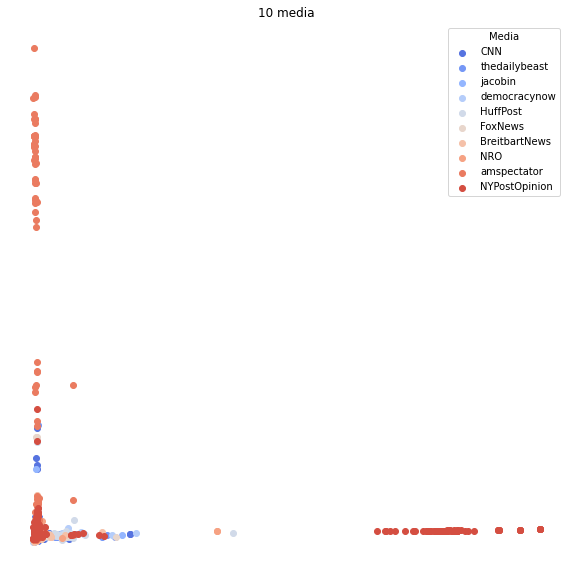

In [59]:
fig, ax = plt.subplots(figsize = (10,10))
ax.axis('off')
pallet = seaborn.color_palette(palette='coolwarm', n_colors = 10)

#Plot
for i in range(10):
    a = np.stack(train_data_df[train_data_df['Media'] == media_list[i]]['pca'])
    ax.scatter(a[:,0], a[:, 1], c = pallet[i], label = media_list[i])
    
ax.legend(loc = 'upper right', title = 'Media')
plt.title('10 media')
plt.show()

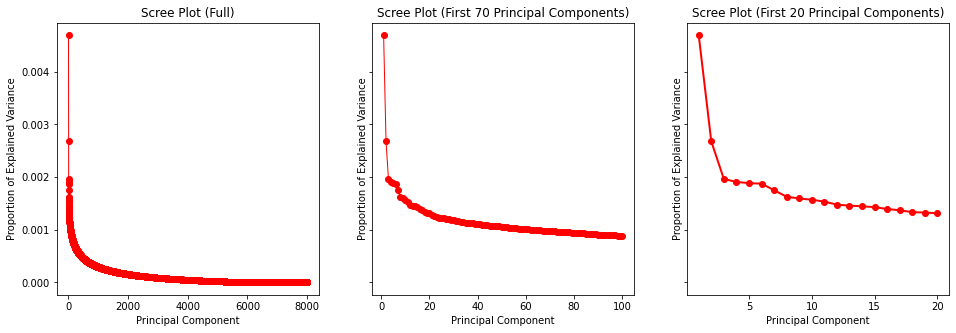

In [48]:
n = len(train_data_df)

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize = (16, 5), sharey=True)

eigen_vals = np.arange(n) + 1
ax1.plot(eigen_vals, pca.explained_variance_ratio_, 'ro-', linewidth=1)
ax1.set_title('Scree Plot (Full)')
ax1.set_xlabel('Principal Component')
ax1.set_ylabel('Proportion of Explained Variance')

eigen_vals = np.arange(100) + 1
ax2.plot(eigen_vals, pca.explained_variance_ratio_[:100], 'ro-', linewidth=1)
ax2.set_title('Scree Plot (First 100 Principal Components)')
ax2.set_xlabel('Principal Component')
ax2.set_ylabel('Proportion of Explained Variance')


eigen_vals = np.arange(20) + 1
ax3.plot(eigen_vals, pca.explained_variance_ratio_[:20], 'ro-', linewidth=2)
ax3.set_title('Scree Plot (First 20 Principal Components)')
ax3.set_xlabel('Principal Component')
ax3.set_ylabel('Proportion of Explained Variance')

plt.show()

In [60]:
train_data_df['pca_reduced_8'] = train_data_df['pca'].apply(lambda x: x[:8])

In [15]:
logistic = sklearn.linear_model.LogisticRegression()
logistic.fit(np.stack(train_data_df['pca_reduced_8'], axis=0), train_data_df['left'])

KeyError: 'pca_reduced_8'

In [63]:
logistic.score(np.stack(train_data_df['pca_reduced_8'], axis=0), train_data_df['left'])

0.6035214785214785

In [64]:
#PCA
reduced_data_test = pca.transform(np.stack(test_data_df['vect'], axis=0))
test_data_df['pca'] = [r for r in reduced_data_test]

KeyError: 'category'

In [66]:
test_data_df['pca_reduced_8'] = test_data_df['pca'].apply(lambda x: x[:8])
#Test
logistic.score(np.stack(test_data_df['pca_reduced_8'], axis=0), test_data_df['left'])

0.6068931068931069

In [69]:
train_data_df['pca_reduced_100'] = train_data_df['pca'].apply(lambda x: x[:100])
test_data_df['pca_reduced_100'] = test_data_df['pca'].apply(lambda x: x[:100])

logistic.fit(np.stack(train_data_df['pca_reduced_100'], axis=0), train_data_df['left'])

print("Training:")
print(logistic.score(np.stack(train_data_df['pca_reduced_100'], axis=0), train_data_df['left']))
print("Testing:")
print(logistic.score(np.stack(test_data_df['pca_reduced_100'], axis=0), test_data_df['left']))

Training:
0.7333916083916084
Testing:
0.7187812187812188


In [70]:
train_data_df['pca_reduced_200'] = train_data_df['pca'].apply(lambda x: x[:200])
test_data_df['pca_reduced_200'] = test_data_df['pca'].apply(lambda x: x[:200])

logistic.fit(np.stack(train_data_df['pca_reduced_200'], axis=0), train_data_df['left'])

print("Training:")
print(logistic.score(np.stack(train_data_df['pca_reduced_200'], axis=0), train_data_df['left']))
print("Testing:")
print(logistic.score(np.stack(test_data_df['pca_reduced_200'], axis=0), test_data_df['left']))

Training:
0.7552447552447552
Testing:
0.7312687312687313


In [72]:
train_data_df['pca_reduced_400'] = train_data_df['pca'].apply(lambda x: x[:400])
test_data_df['pca_reduced_400'] = test_data_df['pca'].apply(lambda x: x[:400])

logistic.fit(np.stack(train_data_df['pca_reduced_400'], axis=0), train_data_df['left'])

print("Training:")
print(logistic.score(np.stack(train_data_df['pca_reduced_400'], axis=0), train_data_df['left']))
print("Testing:")
print(logistic.score(np.stack(test_data_df['pca_reduced_400'], axis=0), test_data_df['left']))

Training:
0.7935814185814186
Testing:
0.7662337662337663


In [20]:
logistic_l1= sklearn.linear_model.LogisticRegression(penalty='l2')
logistic_l1.fit(np.stack(train_data_df['vect'], axis=0), train_data_df['left'])

LogisticRegression()

In [16]:
print(logistic_l1.score(np.stack(train_data_df['vect'], axis=0), train_data_df['left']))
print(logistic_l1.score(np.stack(test_data_df['vect'], axis=0), test_data_df['left']))

0.9376873126873126
0.8301698301698301


### Task 2: Confusion matrix visualization

In [75]:
test_data_df['category'] = test_data_df['left']

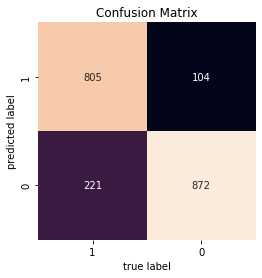

In [76]:
lucem_illud.plotConfusionMatrix(logistic_l1, test_data_df)

### Task 3: Precision, recall, F-measure, AUC, and ROC visualization

In [81]:
evaluation_table = lucem_illud.evaluateClassifier(logistic_l1, test_data_df)

In [86]:
def calculate_f(precision, recall):
    return 2 * precision * recall / (precision + recall)

evaluation_table['F-measure'] = evaluation_table.apply(lambda x: 2 * x.Precision * x['Recall'] / (x['Precision'] + x['Recall']), axis=1)

In [87]:
evaluation_table

,Error_Rate,AUC,Precision,Average_Precision,Recall,F-measure
Category,,,,,,
0,0.162338,0.839022,0.885589,0.805223,0.784600,0.832041
1,0.162338,0.839022,0.797804,0.764740,0.893443,0.842919


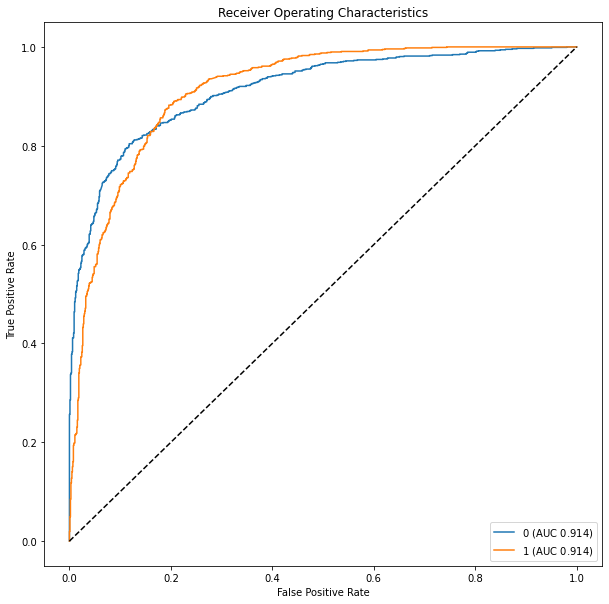

In [79]:
lucem_illud.plotMultiROC(logistic_l1, test_data_df)

### Task 4: How do these classifiers perform?

1. The PCA didn't do a very good job, the left- and right- media completely clustered together. 
2. The logistic regression with only the first 8 components from PCA as its features only gives an accuracy of 0.6. However, as the number of features(i.e. kepted components) grows, the precision also increases.
3. The logistic regression with L1 regularization did an excellent job, that it gives an accuracy of 83.7% on the testing sample.
4. This implies there are indeed some distinguish features between left- ans right- media.

### Task 5: Extrapolation

In [21]:
TFVects_test = TFVectorizer.transform(tweets_extra_df['Text'])
tweets_extra_df['vect'] = [np.array(v).flatten() for v in TFVects_test.todense()]

In [22]:
logistic_l1_ex = logistic_l1.predict(np.stack(tweets_extra_df['vect'], axis=0))

In [25]:
sum(logistic_l1_ex)/len(logistic_l1_ex)

0.24975024975024976

The logistic regression classifier with L1 regulariation thinks that the Real Clear Politics is very right-skewed.

-----

# Decision Trees

Decision trees can be used to predict both categorical/class labels (i.e., classification) and continuous labels (i.e., regression).

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

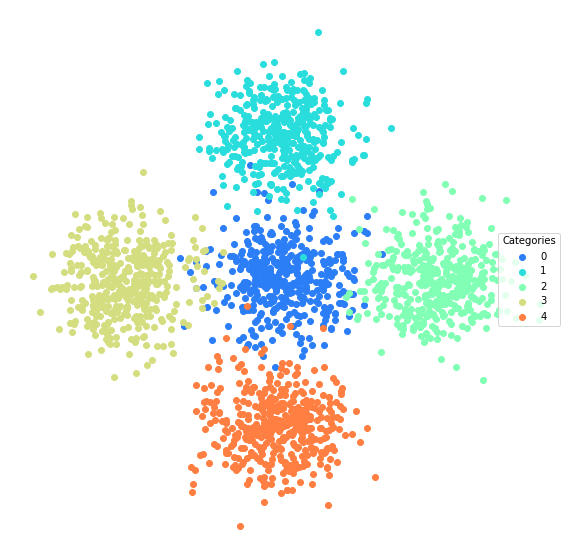

In [88]:
blobs_df = lucem_illud.multiBlobs(noise=.2, centers=[(0,0), (0,5), (5,0), (-5,0), (0,-5)])
df_exampleTree_train, df_exampleTree_test = sklearn.model_selection.train_test_split(blobs_df, test_size=.2)
lucem_illud.plotter(df_exampleTree_train)

Now we import our Decision Tree classifier from sklearn.tree (familiar syntax) and fit it using the fit method.

In [ ]:
clf_tree = sklearn.tree.DecisionTreeClassifier(max_depth=4,random_state=0)
clf_tree.fit(np.stack(df_exampleTree_train['vect'], axis =0), df_exampleTree_train['category'])

To see what's going on visually with the classification: 

In [ ]:
lucem_illud.plotregions(clf_tree, df_exampleTree_train)

In [ ]:
lucem_illud.evaluateClassifier(clf_tree, df_exampleTree_test)

Lets look at accuracy:

In [ ]:
sklearn.metrics.accuracy_score(df_exampleTree_test['category'],clf_tree.predict(np.stack(df_exampleTree_test['vect'], axis = 0)))

What happens if we trim the tree?

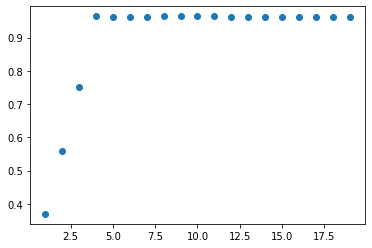

In [98]:
depthvec = []
scorevec = []
for i in range(1,20):
    tree2 = sklearn.tree.DecisionTreeClassifier(max_depth=i,random_state=0)
    tree2.fit(np.stack(df_exampleTree_train['vect'], axis =0), df_exampleTree_train['category'])
    score = sklearn.metrics.accuracy_score(df_exampleTree_test['category'], tree2.predict(np.stack(df_exampleTree_test['vect'], axis = 0)))
    depthvec.append(i)
    scorevec.append(score)
plt.scatter(depthvec,scorevec)
plt.show()

We can select different layers of the decision tree or "prune" it. At approximately four layers down in the decision tree, the shape is somewhat odd, suggesting that our model is overfitting beyond those four layers.

Combining multiple overfitting estimators turns out to be a key idea in machine learning. This is called **bagging** and is a type of **ensemble** method. The idea is to make many randomized estimators--each can overfit, as decision trees are wont to do--but then to combine them, ultimately producing a better classification. A **random forest** is produced by bagging decision trees.

In [ ]:
tree = sklearn.tree.DecisionTreeClassifier(max_depth=10) #Create an instance of our decision tree classifier.

bag = sklearn.ensemble.BaggingClassifier(tree, n_estimators=100, max_samples=0.8, random_state=1) #Each tree uses up to 80% of the data

In [ ]:
bag.fit(np.stack(df_exampleTree_train['vect'], axis =0), df_exampleTree_train['category']) #Fit the bagged classifier

In [ ]:
lucem_illud.plotregions(bag, df_exampleTree_test)

In [ ]:
lucem_illud.evaluateClassifier(bag, df_exampleTree_test)

In [ ]:
lucem_illud.plotConfusionMatrix(bag, df_exampleTree_test)

-----

## <font color="red">*Exercise 3*</font>

<font color="red">In the cells immediately following, perform decision tree and random forest classification (binary, multinomial or continuous) using training, testing and extrapolation (uncoded) data from texts and hand-classifications associated with your final project. As with ***Exercise 2***, these could be crowd-sourced codes gathered through Amazon Mechanical Turk last week. Visualize the classification of data points. Calculate relevant metrics (e.g., precision, recall, the F-measure, and AUC). Now build an ensemble classifier by bagging trees into a random forest. Visualize the result. How do these classifiers perform? What does ensemble learning do?

### Task 1: Decision tree and performance evaluation

In [27]:
clf_tree = sklearn.tree.DecisionTreeClassifier(max_depth=4,random_state=0)
clf_tree.fit(np.stack(train_data_df['vect'], axis =0), train_data_df['left'])

DecisionTreeClassifier(max_depth=4, random_state=0)

In [96]:
train_data_df['category'] = train_data_df['left']
lucem_illud.evaluateClassifier(clf_tree, test_data_df)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.481019,0.530602,0.943662,0.540644,0.065302
1,0.481019,0.530602,0.503366,0.503301,0.995902


In [97]:
sklearn.metrics.accuracy_score(test_data_df['left'],clf_tree.predict(np.stack(test_data_df['vect'], axis = 0)))

0.518981018981019

In [104]:
lucem_illud.evaluateClassifier(bag, test_data_df)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.42008,0.589607,0.903930,0.591463,0.201754
1,0.42008,0.589607,0.538071,0.536931,0.977459


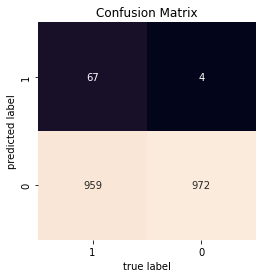

In [103]:
lucem_illud.plotConfusionMatrix(clf_tree, test_data_df)

### Task 2: Random forest and performance evaluation

In [28]:
tree = sklearn.tree.DecisionTreeClassifier(max_depth=10) #Create an instance of our decision tree classifier.

bag = sklearn.ensemble.BaggingClassifier(tree, n_estimators=100, max_samples=0.8, random_state=1) #Each tree uses up to 80% of the data

In [30]:
bag.fit(np.stack(train_data_df['vect'], axis =0), train_data_df['left'])

BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=10),
                  max_samples=0.8, n_estimators=100, random_state=1)

In [107]:
sklearn.metrics.accuracy_score(test_data_df['left'],bag.predict(np.stack(test_data_df['vect'], axis = 0)))

0.5799200799200799

In [106]:
lucem_illud.evaluateClassifier(bag, test_data_df)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.42008,0.589607,0.903930,0.591463,0.201754
1,0.42008,0.589607,0.538071,0.536931,0.977459


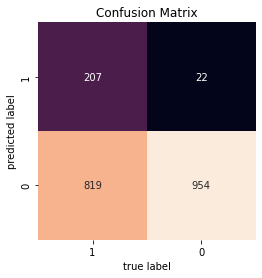

In [102]:
lucem_illud.plotConfusionMatrix(bag, test_data_df)

The decision tree classfiers seem to be classifying all of the tweets as Right. The Random forest did a slightly better job, but still only got an accuracy rate as low as 0.58.

### Task 3: What does ensemble learning do?

I found a clear answer from google:
* Step 1: Select n (e.g. 1000) random subsets from the training set
* Step 2: Train n (e.g. 1000) decision trees. One random subset is used to train one decision tree. The optimal splits for each decision tree are based on a random subset of features (e.g. 10 features in total, randomly select 5 out of 10 features to split)
* Step 3: Each individual tree predicts the records/candidates in the test set, independently.
* Step 4: Make the final prediction

### Task 4: Extrapolation with decision tree and random forest

In [31]:
tree_ex = clf_tree.predict(np.stack(tweets_extra_df['vect'], axis=0))
sum(tree_ex)/len(tree_ex)

0.5274725274725275

In [32]:
bag_ex = bag.predict(np.stack(tweets_extra_df['vect'], axis=0))
sum(bag_ex)/len(bag_ex)

0.3926073926073926

The tree classifier thinks the Real Clear Politics is neutral, and the random forest classifier thinks it to be slightly right. It's surprising that they didn't lable it as far right given how they had treated the train and test datasets.

-----

# K-Nearest Neighbors

The K-Nearest neighbors classifier takes a simpler premise than those before: Find the closest labeled datapoint in set and "borrow" its label.

Let's use newsgroup data again.

In [109]:
newsgroupsDF = lucem_illud.loadNewsGroups()

Loading data for: comp.sys.mac.hardware
Loading data for: comp.windows.x
Loading data for: misc.forsale
Loading data for: rec.autos
Converting to vectors


D:\MySoftware\python310\lib\site-packages\spacy\pipeline\lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)
D:\MySoftware\python310\lib\site-packages\spacy\pipeline\lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


In [110]:
newsgroupsDF[:5]

,text,category,source_file,tokenized_text,normalized_text,vect
0,"\tIn certain Apple 13"" RGB monitors there has ...",comp.sys.mac.hardware,../data\20news_home\20news-bydate-train\comp.s...,"[In, certain, Apple, 13, RGB, monitors, there,...","[certain, apple, rgb, monitors, problem, high,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,Does anyone know how to reach Micron? I am in...,comp.sys.mac.hardware,../data\20news_home\20news-bydate-train\comp.s...,"[Does, anyone, know, how, to, reach, Micron, I...","[know, reach, micron, interested, getting, spe...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,Hi there!\n\nCould some kind soul tell me what...,comp.sys.mac.hardware,../data\20news_home\20news-bydate-train\comp.s...,"[Hi, there, Could, some, kind, soul, tell, me,...","[hi, kind, soul, tell, price, lc, iivi, iivx, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,"""auto\nfrom",comp.sys.mac.hardware,../data\20news_home\20news-bydate-train\comp.s...,"[auto, from]",[auto],"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,\n\n Don't believe the hype. There is no su...,comp.sys.mac.hardware,../data\20news_home\20news-bydate-train\comp.s...,"[Do, n't, believe, the, hype, There, is, no, s...","[believe, hype, thing, powerpc, slot]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


Make a testing and training set:

In [111]:
holdBackFraction = .2
train_ng_df, test_ng_df = sklearn.model_selection.train_test_split(newsgroupsDF, test_size=holdBackFraction)

Let's initialize our k-nearest neighbors classifier:

In [33]:
n_neighbors = 15
weights="uniform"
clf_knearest = sklearn.neighbors.KNeighborsClassifier(n_neighbors, weights=weights)

Let's try to classify using the TF-IDF vectors:

In [113]:
TFVectorizer_ng = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=2, stop_words='english', norm='l2')
TFVects_ng = TFVectorizer_ng.fit_transform(train_ng_df['text'])
train_ng_df['vect'] = [np.array(v).flatten() for v in TFVects_ng.todense()]

In [114]:
clf_knearest.fit(np.stack(train_ng_df['vect'], axis = 0), train_ng_df['category'])

KNeighborsClassifier(n_neighbors=15)

In [115]:
lucem_illud.evaluateClassifier(clf_knearest, train_ng_df)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
comp.sys.mac.hardware,0.307979,0.603251,0.382524,0.303365,0.430131
comp.windows.x,0.251596,0.501055,1.000000,0.253705,0.002110
rec.autos,0.543617,0.579356,0.299330,0.292217,0.832298
misc.forsale,0.238298,0.519723,0.904762,0.274203,0.040860


And lets look at the testing data

In [116]:
#Create vectors
TFVects_test = TFVectorizer_ng.transform(test_ng_df['text'])
test_ng_df['vect'] = [np.array(v).flatten() for v in TFVects_test.todense()]

#Add to df
test_ng_df['nb_predict'] = clf_knearest.predict(np.stack(test_ng_df['vect'], axis=0))

#Test
print("Testing score:")
print(clf_knearest.score(np.stack(test_ng_df['vect'], axis=0), test_ng_df['category']))

Testing score:
0.27872340425531916


Let's produce another confusion matrix:

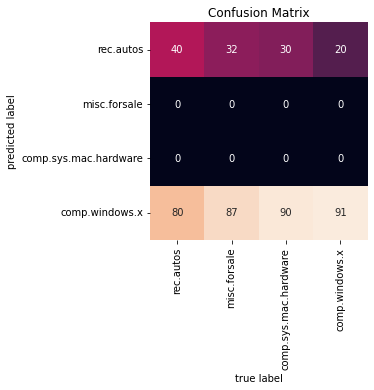

In [117]:
lucem_illud.plotConfusionMatrix(clf_knearest, test_ng_df)

You can produce the PCA space visual if you want, altough it can take a very long time, so we'll leave it optionally commented out:

In [ ]:
#lucem_illud.plotregions(clf_knearest, test_ng_df)

------

## <font color="red">*Exercise 4*</font>

<font color="red">In the cells immediately following, perform and visualize k-nearest neighbor classification using training, testing and extrapolation (uncoded) data from texts and hand-classifications associated with your final project. Visualize the classification of data points and calculate relevant metrics (e.g., precision, recall, the F-measure, and AUC). Articulate how the *k*-nearest neighbor approach relates to *k*-means clustering explored in ***week 3***?

### Task 1: Perform and visualize knn

In [36]:
clf_knearest.fit(np.stack(train_data_df['vect'], axis = 0), train_data_df['left'])

KNeighborsClassifier(n_neighbors=15)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


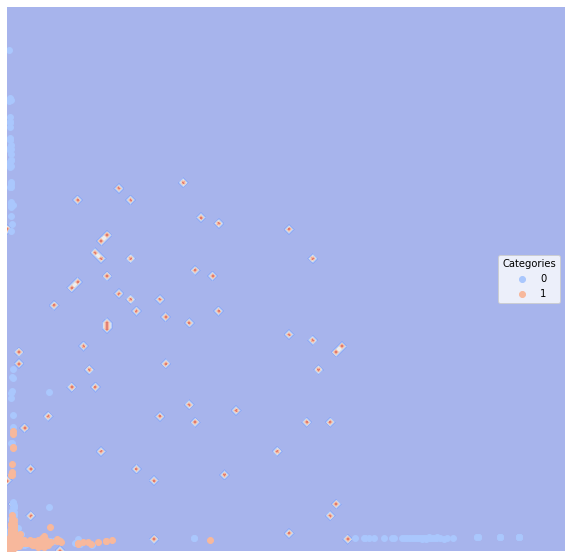

In [119]:
lucem_illud.plotregions(clf_knearest, train_data_df)

### Task 2: Evaluation

In [121]:
lucem_illud.evaluateClassifier(clf_knearest, train_data_df)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.450674,0.552089,0.524516,0.524370,0.994722
1,0.450674,0.552089,0.954545,0.552533,0.109456


In [129]:
test_data_df['nb_predict'] = clf_knearest.predict(np.stack(test_data_df['vect'], axis=0))

#Test
print("Testing score:")
print(clf_knearest.score(np.stack(test_data_df['vect'], axis=0), test_data_df['category']))

Testing score:
0.531968031968032


In [130]:
lucem_illud.evaluateClassifier(clf_knearest, test_data_df)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.468032,0.520179,0.522856,0.522775,0.992203
1,0.468032,0.520179,0.854545,0.505187,0.048156


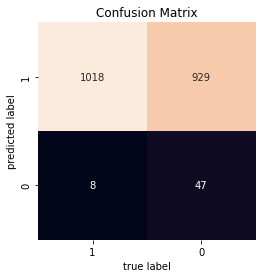

In [131]:
lucem_illud.plotConfusionMatrix(clf_knearest, test_data_df)

It's interesting that the KNN did exactly the opposite to decision tree and ramdon forest: It turns to label every tweets as left. I think it's just a sign that these three classifiers simply cannot tell the two parties apart.

### Task 3: How the knn relates to k-means clustering?

K-means clustering represents an unsupervised algorithm, mainly used for clustering, while KNN is a supervised learning algorithm used for classification.

### Task 4: Extrapolation

In [37]:
knn_ex = clf_knearest.predict(np.stack(tweets_extra_df['vect'], axis=0))
sum(knn_ex)/len(knn_ex)

0.017982017982017984

The KNN classifier labeled nearly every tweets as right. I think I know what is happening here: the KNN classifier only learned some features from the training set that are irrelevant to political skewness. So when seeing this new datasets, from a media not occurred in the training set, the KNN classifier simply labelled it as "different".

-----

# SVMs

Now we will examine Support Vector Machines, an approach that creates the partition that preserves the "maximum margin" between classes.

We will use a few sub forums from reddit--which tend to share text rather than memes--namely `talesfromtechsupport`, `badroommates`, `weeabootales` and `relationships`. The top 100 text posts from each have been saved to `data/reddit.csv`.

In [133]:
import pandas

In [134]:
redditDf = pandas.read_csv('../data/reddit.csv', index_col = 0)

#Drop a couple missing values

redditDf = redditDf.dropna()

#Set category

redditDf['category'] = redditDf['subreddit']

#tokenize and normalize
redditDf['tokenized_text'] = redditDf['text'].apply(lambda x: lucem_illud.word_tokenize(x))
redditDf['normalized_text'] = redditDf['tokenized_text'].apply(lambda x: lucem_illud.normalizeTokens(x))

D:\MySoftware\python310\lib\site-packages\spacy\pipeline\lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)
D:\MySoftware\python310\lib\site-packages\spacy\pipeline\lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


We will tf.idf the data to make our vectors:

In [137]:
redditTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.5, min_df=3, stop_words='english', norm='l2')
redditTFVects = redditTFVectorizer.fit_transform([' '.join(l) for l in redditDf['normalized_text']])
redditDf['vect'] = [np.array(v).flatten() for v in redditTFVects.todense()]

Initilize the model and make a train test split:

In [138]:
holdBackFraction = .2
train_redditDf, test_redditDf = sklearn.model_selection.train_test_split(redditDf, test_size=holdBackFraction)

In [139]:
clf_svm = sklearn.svm.SVC(kernel='linear', probability = False)
#probability = True is slower but  lets you call predict_proba()
clf_svm.fit(np.stack(train_redditDf['vect'], axis=0), train_redditDf['category'])

SVC(kernel='linear')

...and consider the results:

In [140]:
lucem_illud.evaluateClassifier(clf_svm, test_redditDf)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
Relationships,0.018750,0.982726,0.930556,0.919996,0.985294
Weeaboo Tales: stories about the extreme fans of japanese culture,0.009375,0.981707,1.000000,0.972790,0.963415
Bad Roommates: Tales of Irritation,0.009375,0.982143,1.000000,0.973661,0.964286
Tales From Tech Support,0.006250,0.995726,0.977273,0.977273,1.000000


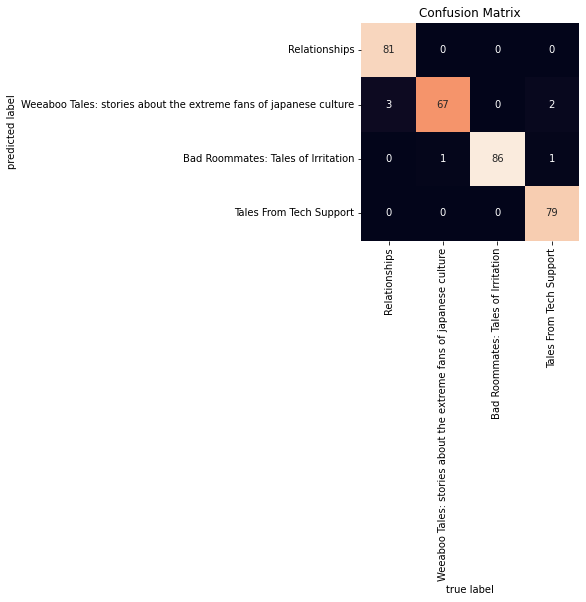

In [141]:
lucem_illud.plotConfusionMatrix(clf_svm, test_redditDf)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

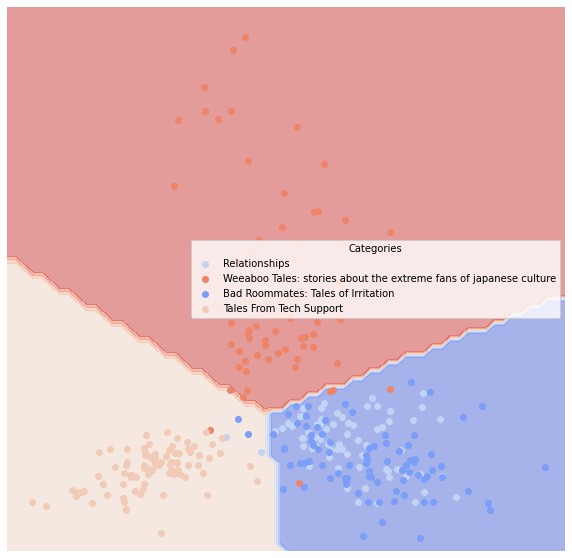

In [142]:
lucem_illud.plotregions(clf_svm, test_redditDf)

# Neural Nets

We include an example of a simple neural network, the Multi-layer Perceptron (MLP) that learns a function $f(\cdot): R^m \rightarrow R^o$ by training on a dataset, where $m$ is the number of dimensions for input and $o$ is the number of dimensions for output. Given a set of features $X = {x_1, x_2, ..., x_m}$ and a target $y$, it can learn a non-linear function approximator for either classification or regression. It is different from logistic regression, in that between the input and the output layer, there can be one or more non-linear layers, called hidden layers. The following figure shows a one hidden layer MLP with scalar output. ![title](../data/multilayerperceptron_network.png) The leftmost layer, known as the input layer, consists of a set of "neurons" $\{x_i | x_1, x_2, ..., x_m\}$ representing the input features (e.g., weighted words). Each neuron in the hidden layer transforms the values from the previous layer with a weighted linear summation $w_1x_1 + w_2x_2 + ... + w_mx_m$, followed by a non-linear activation function $g(\cdot):R \rightarrow R$ - like the logistic or hyperbolic tan function. The output layer receives the values from the last hidden layer and transforms them into output values.

In [ ]:
clf_nn = sklearn.neural_network.MLPClassifier()
clf_nn.fit(np.stack(train_redditDf['vect'], axis=0), train_redditDf['category'])

In [ ]:
lucem_illud.evaluateClassifier(clf_nn, test_redditDf)

In [ ]:
lucem_illud.plotConfusionMatrix(clf_nn, test_redditDf)

In [ ]:
lucem_illud.plotregions(clf_nn, test_redditDf)

It performs very well.

-----

## <font color="red">*Exercise 5*</font>

<font color="red">In the cells immediately following, perform a neural network classification and calculate relevant metrics (e.g., precision, recall, the F-measure, and AUC). How does this classify relevant to *k*-nearest neighbor, logistic and decision-tree approaches?

In [11]:
clf_nn = sklearn.neural_network.MLPClassifier()
clf_nn.fit(np.stack(train_data_df['vect'], axis=0), train_data_df['left'])

MLPClassifier()

In [14]:
#Test
print("Testing score:")
print(clf_nn.score(np.stack(test_data_df['vect'], axis=0), test_data_df['category']))

Testing score:
0.8236763236763237


In [13]:
test_data_df['category'] = test_data_df['left']
lucem_illud.evaluateClassifier(clf_nn, test_data_df)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.176324,0.823706,0.831129,0.769734,0.813745
1,0.176324,0.823706,0.816487,0.763595,0.833667


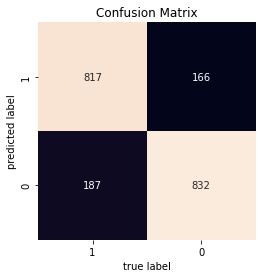

In [15]:
lucem_illud.plotConfusionMatrix(clf_nn, test_data_df)

Very impressive. The test score is as high as 82.4%. But here we also got a very surprising result: Recall that the test accuracy of logistic regression with L1 regularization is 83.8%, which, even outperform neural network.

-----

## Classification with BERT Pipelines
Now, instead of classifying based on "old" NLP methods, we will now use the popular Transformers package default 'pipelines'. This package has methods for a wide range of common NLP tasks using contextual word embeddings. Note that for this homework, we are not building new contextual models ourselves, merely using existing models in Transformers. We will spend Weeks 7 and 8 learning more about Transformers, so do not worry about fully understanding them this week.

[Transformers Documentation](https://huggingface.co/transformers/)

[Transformers GitHub](https://github.com/huggingface/transformers)

The following sections of code are taken from the [Summary of Tasks](https://huggingface.co/transformers/task_summary.html) page in the Transformers documentation.

### Sequence Classification (e.g., sentiment)
Sequence classification is the task of classifying sequences according to a given number of classes. An example of
sequence classification is the GLUE dataset. If you would like to fine-tune a
model on a GLUE sequence classification task, you may leverage the [run_glue.py](https://github.com/huggingface/transformers/tree/master/examples/text-classification/run_glue.py) and
[run_pl_glue.py](https://github.com/huggingface/transformers/tree/master/examples/text-classification/run_pl_glue.py) or
[run_tf_glue.py](https://github.com/huggingface/transformers/tree/master/examples/text-classification/run_tf_glue.py) scripts.

Here is an example of using pipelines to do sentiment analysis: identifying if a sentence is positive or negative. It
leverages a fine-tuned model on sst2, which is a GLUE task.

This returns a label ("POSITIVE" or "NEGATIVE") alongside a score, as follows:

In [33]:
! pip3 install torch===1.10.2 torchvision==0.11.3 torchaudio===0.10.2

ERROR: Could not find a version that satisfies the requirement torch===1.10.2 (from versions: none)
ERROR: No matching distribution found for torch===1.10.2
You should consider upgrading via the 'D:\MySoftware\python310\python.exe -m pip install --upgrade pip' command.


In [23]:
from transformers import pipeline
nlp = pipeline("sentiment-analysis")
result = nlp("I hate you")[0]
print(f"label: {result['label']}, with score: {round(result['score'], 4)}")
result = nlp("I love you")[0]
print(f"label: {result['label']}, with score: {round(result['score'], 4)}")

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english)


RuntimeError: At least one of TensorFlow 2.0 or PyTorch should be installed. To install TensorFlow 2.0, read the instructions at https://www.tensorflow.org/install/ To install PyTorch, read the instructions at https://pytorch.org/.

Here is an example of doing a sequence classification using a model to determine if two sequences are paraphrases of
each other. The process is the following:

1. Instantiate a tokenizer and a model from the checkpoint name. The model is identified as a BERT model and loads it
   with the weights stored in the checkpoint.
2. Build a sequence from the two sentences, with the correct model-specific separators token type ids and attention
   masks (`PreTrainedTokenizer.encode` and `PreTrainedTokenizer.__call__` take
   care of this).
3. Pass this sequence through the model so that it is classified in one of the two available classes: 0 (not a
   paraphrase) and 1 (is a paraphrase).
4. Compute the softmax of the result to get probabilities over the classes.
5. Print the results.

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased-finetuned-mrpc")
model = AutoModelForSequenceClassification.from_pretrained("bert-base-cased-finetuned-mrpc")
classes = ["not paraphrase", "is paraphrase"]
sequence_0 = "The company HuggingFace is based in New York City"
sequence_1 = "Apples are especially bad for your health"
sequence_2 = "HuggingFace's headquarters are situated in Manhattan"
paraphrase = tokenizer(sequence_0, sequence_2, return_tensors="pt")
not_paraphrase = tokenizer(sequence_0, sequence_1, return_tensors="pt")
paraphrase_classification_logits = model(**paraphrase).logits
not_paraphrase_classification_logits = model(**not_paraphrase).logits
paraphrase_results = torch.softmax(paraphrase_classification_logits, dim=1).tolist()[0]
not_paraphrase_results = torch.softmax(not_paraphrase_classification_logits, dim=1).tolist()[0]
# Should be paraphrase
for i in range(len(classes)):
    print(f"{classes[i]}: {int(round(paraphrase_results[i] * 100))}%")
# Should not be paraphrase
for i in range(len(classes)):
    print(f"{classes[i]}: {int(round(not_paraphrase_results[i] * 100))}%")

not paraphrase: 10%
is paraphrase: 90%
not paraphrase: 94%
is paraphrase: 6%

### Extractive Question Answering

Extractive Question Answering is the task of extracting an answer from a text given a question. An example of a
question answering dataset is the SQuAD dataset, which is entirely based on that task. If you would like to fine-tune a
model on a SQuAD task, you may leverage the [run_squad.py](https://github.com/huggingface/transformers/tree/master/examples/question-answering/run_squad.py) and
[run_tf_squad.py](https://github.com/huggingface/transformers/tree/master/examples/question-answering/run_tf_squad.py) scripts.


Here is an example of using pipelines to do question answering: extracting an answer from a text given a question. It
leverages a fine-tuned model on SQuAD.

In [ ]:
from transformers import pipeline
nlp = pipeline("question-answering")
context = r"""
Extractive Question Answering is the task of extracting an answer from a text given a question. An example of a
question answering dataset is the SQuAD dataset, which is entirely based on that task. If you would like to fine-tune
a model on a SQuAD task, you may leverage the examples/question-answering/run_squad.py script.
"""

This returns an answer extracted from the text, a confidence score, alongside "start" and "end" values, which are the
positions of the extracted answer in the text.

In [ ]:
result = nlp(question="What is extractive question answering?", context=context)
print(f"Answer: '{result['answer']}', score: {round(result['score'], 4)}, start: {result['start']}, end: {result['end']}")
result = nlp(question="What is a good example of a question answering dataset?", context=context)
print(f"Answer: '{result['answer']}', score: {round(result['score'], 4)}, start: {result['start']}, end: {result['end']}")

Answer: 'the task of extracting an answer from a text given a question.', score: 0.6226, start: 34, end: 96
Answer: 'SQuAD dataset,', score: 0.5053, start: 147, end: 161

Here is an example of question answering using a model and a tokenizer. The process is the following:

1. Instantiate a tokenizer and a model from the checkpoint name. The model is identified as a BERT model and loads it
   with the weights stored in the checkpoint.
2. Define a text and a few questions.
3. Iterate over the questions and build a sequence from the text and the current question, with the correct
   model-specific separators token type ids and attention masks.
4. Pass this sequence through the model. This outputs a range of scores across the entire sequence of tokens (question and
   text), for both the start and end positions.
5. Compute the softmax of the result to get probabilities over the tokens.
6. Fetch the tokens from the identified start and stop values, convert those tokens to a string.
7. Print the results.

In [ ]:
from transformers import AutoTokenizer, AutoModelForQuestionAnswering
import torch
tokenizer = AutoTokenizer.from_pretrained("bert-large-uncased-whole-word-masking-finetuned-squad")
model = AutoModelForQuestionAnswering.from_pretrained("bert-large-uncased-whole-word-masking-finetuned-squad")
text = r"""
🤗 Transformers (formerly known as pytorch-transformers and pytorch-pretrained-bert) provides general-purpose
architectures (BERT, GPT-2, RoBERTa, XLM, DistilBert, XLNet…) for Natural Language Understanding (NLU) and Natural
Language Generation (NLG) with over 32+ pretrained models in 100+ languages and deep interoperability between
TensorFlow 2.0 and PyTorch.
"""
questions = [
    "How many pretrained models are available in 🤗 Transformers?",
    "What does 🤗 Transformers provide?",
    "🤗 Transformers provides interoperability between which frameworks?",
]
for question in questions:
    inputs = tokenizer(question, text, add_special_tokens=True, return_tensors="pt")
    input_ids = inputs["input_ids"].tolist()[0]

    text_tokens = tokenizer.convert_ids_to_tokens(input_ids)
    outputs = model(**inputs)
    answer_start_scores = outputs.start_logits
    answer_end_scores = outputs.end_logits

    answer_start = torch.argmax(
        answer_start_scores
    )  # Get the most likely beginning of answer with the argmax of the score
    answer_end = torch.argmax(answer_end_scores) + 1  # Get the most likely end of answer with the argmax of the score

    answer = tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(input_ids[answer_start:answer_end]))

    print(f"Question: {question}")
    print(f"Answer: {answer}")

Question: How many pretrained models are available in 🤗 Transformers?
Answer: over 32 +
Question: What does 🤗 Transformers provide?
Answer: general - purpose architectures
Question: 🤗 Transformers provides interoperability between which frameworks?
Answer: tensorflow 2 . 0 and pytorch

-----

## <font color="red">*Exercise 6*</font>

<font color="red">In the cells immediately following, use the pipeline functions or the word or sentence vector functions (e.g., similarity) to explore the social game underlying the production and meaning of texts associated with your final project. How does BERT help you gain insight regarding your research question that is similar and different from prior methods?

In [ ]:
from transformers import pipeline
nlp = pipeline("sentiment-analysis")
tweets_df['sentiment_result'] = tweets_df['Text'].apply(lambda x: nlp(x)[0])

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english)


In [ ]:
tweets_df['sentiment_label'] = tweets_df['sentiment_result'].apply(lambda x: x['label'])

In [ ]:
tweets_df['sentiment_score'] = tweets_df['sentiment_result'].apply(lambda x: x['score'])

In [ ]:
tweets_df['positive'] = tweets_df['sentiment_label'].apply(lambda x: x == 'POSITIVE')

In [ ]:
tweets_df.groupby('left').mean()['positive']

left
0    0.130470
1    0.223177
Name: positive, dtype: float64

So...Both media are very unhappy, and right-skewed media is worse.

In [ ]:
tweets_df.groupby('Media').mean()['positive'].sort_values()

Media
NYPostOpinion    0.107892
BreitbartNews    0.119880
FoxNews          0.127872
NRO              0.138861
democracynow     0.140859
amspectator      0.157842
thedailybeast    0.160839
CNN              0.250749
HuffPost         0.258741
jacobin          0.304695
Name: positive, dtype: float64